<a href="https://colab.research.google.com/github/tanishi22/FYP/blob/main/Code/ML/final_binary_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Gene Essentiality Prediction with 5-fold Cross Validation: Intrinsic and Extrinsic Features**

This notebook aims to perform binary classification of essential vs non-essential genes from Drosophila melanogaster using both extrinsic and intrinsic gene features.

**Intrinsic features (n = 10020)** and **extrinsic features (n = 107)** across all **essential (n = 2081)** and **non-essential genes (n = 3764)** have been extracted and merged into dataframes called intrinsic_df and extrinsic_df, respectively. These dataframes have all the corresponding essentiality labels for the FBgn_IDs.

**Classifiers:** Logistic Regression (LR), Support Vector Machine (SVM), Random Forest (RF), Gradient Boosting Model (GBM), Xtreme Gradient Boosting (XGB), and a Multi-Layer Perceptron (MLP) Classifier (simple neural network)

**Important links:**

Feature selection: https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel

Cross validation: https://scikit-learn.org/stable/modules/cross_validation.html

ROC interpretation on CV data: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

Hyperparameter tuning: https://scikit-learn.org/stable/modules/grid_search.html

Assessing feature importance: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

# **Load Dependencies**

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, make_scorer, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Prevent harmless sklearn warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **Load and merge feature data**

In [ ]:
# change file paths accordingly
intrinsic_file_path = "/content/drive/My Drive/ICL/FYP/Data/intrinsic_df.csv"
extrinsic_file_path = "/content/drive/My Drive/ICL/FYP/Data/extrinsic_df.csv"

In [ ]:
# Load intrinsic data and inspect dimensions and labels
intrinsic_df = pd.read_csv(intrinsic_file_path)
intrinsic_df.head()

Unnamed: 0      FBgn_ID  gc_content  theoretical_pi      Tiny     Small  \
0           0  FBgn0010612    0.583333        4.759690  0.303030  0.505051   
1           1  FBgn0003517    0.622386        9.776537  0.266667  0.525926   
2           2  FBgn0015376    0.519450        5.507063  0.273917  0.485398   
3           3  FBgn0004868    0.573574        8.674255  0.259594  0.469526   
4           4  FBgn0013733    0.526800        5.500341  0.261442  0.481772   

   Aliphatic  Aromatic  Non.polar     Polar  ...  Num_Isoforms  \
0   0.272727  0.101010   0.626263  0.373737  ...           3.0   
1   0.229630  0.100000   0.540741  0.459259  ...           4.0   
2   0.199396  0.099698   0.491440  0.508560  ...           1.0   
3   0.225734  0.117381   0.539503  0.460497  ...           3.0   
4   0.227144  0.065531   0.457240  0.542760  ...          22.0   

   Longest_Isoform_Length  mode_chromosome_name  gene_length  \
0                   300.0                    2L        878.0   
1                   813.0                     X       1617.0   
2                  2982.0                    2L       4519.0   
3                  1332.0                    2L       3701.0   
4                 26418.0                    2R      77874.0   

   coding_gene_length  five_utr_length  three_utr_length  cdna_coding_length  \
0          150.000000             26.5             380.0          150.000000   
1          406.500000            132.0              90.0          406.500000   
2          248.500000            130.0             124.0          248.500000   
3          444.000000            181.0             148.0          444.000000   
4          978.444444            153.5            1117.0          978.444444   

   exon_chrom_length  label  
0         244.333333      1  
1         517.500000      1  
2         269.666667      1  
3         553.666667      1  
4         994.357143      1  

[5 rows x 10022 columns]

In [ ]:
print(intrinsic_df["label"].value_counts(dropna=False))

label
0    3764
1    2081
Name: count, dtype: int64


In [ ]:
# Drop any unnamed index column
intrinsic_features = intrinsic_df.drop(columns=[col for col in ['Unnamed: 0'] if col in intrinsic_df.columns])
intrinsic_features.head()

FBgn_ID  gc_content  theoretical_pi      Tiny     Small  Aliphatic  \
0  FBgn0010612    0.583333        4.759690  0.303030  0.505051   0.272727   
1  FBgn0003517    0.622386        9.776537  0.266667  0.525926   0.229630   
2  FBgn0015376    0.519450        5.507063  0.273917  0.485398   0.199396   
3  FBgn0004868    0.573574        8.674255  0.259594  0.469526   0.225734   
4  FBgn0013733    0.526800        5.500341  0.261442  0.481772   0.227144   

   Aromatic  Non.polar     Polar   Charged  ...  Num_Isoforms  \
0  0.101010   0.626263  0.373737  0.191919  ...           3.0   
1  0.100000   0.540741  0.459259  0.259259  ...           4.0   
2  0.099698   0.491440  0.508560  0.278953  ...           1.0   
3  0.117381   0.539503  0.460497  0.288939  ...           3.0   
4  0.065531   0.457240  0.542760  0.308234  ...          22.0   

   Longest_Isoform_Length  mode_chromosome_name  gene_length  \
0                   300.0                    2L        878.0   
1                   813.0                     X       1617.0   
2                  2982.0                    2L       4519.0   
3                  1332.0                    2L       3701.0   
4                 26418.0                    2R      77874.0   

   coding_gene_length  five_utr_length  three_utr_length  cdna_coding_length  \
0          150.000000             26.5             380.0          150.000000   
1          406.500000            132.0              90.0          406.500000   
2          248.500000            130.0             124.0          248.500000   
3          444.000000            181.0             148.0          444.000000   
4          978.444444            153.5            1117.0          978.444444   

   exon_chrom_length  label  
0         244.333333      1  
1         517.500000      1  
2         269.666667      1  
3         553.666667      1  
4         994.357143      1  

[5 rows x 10021 columns]

In [ ]:
# Load extrinsic data and inspect shape
extrinsic_df = pd.read_csv(extrinsic_file_path)
extrinsic_df.head()

Unnamed: 0      FBgn_ID  biological_process  cellular_component  \
0           0  FBgn0000008                 1.0                 2.0   
1           1  FBgn0000014               260.0                40.0   
2           2  FBgn0000015               234.0                18.0   
3           3  FBgn0000017                35.0                 0.0   
4           4  FBgn0000018                28.0                21.0   

   molecular_function                                       goslim_terms  \
0                 2.0               ['anatomical structure development']   
1                70.0  ['organelle', 'nucleus', 'DNA binding', 'trans...   
2                45.0  ['organelle', 'nucleus', 'DNA binding', 'anato...   
3                25.0  ['anatomical structure development', 'catalyti...   
4                21.0  ['organelle', 'chromosome', 'nucleus', 'regula...   

  ensembl_peptide_id signalp_prediction  signalp_other  signalp_sp_sec_spi  \
0        FBpp0071678              OTHER            1.0            0.000002   
1        FBpp0082829              OTHER            1.0            0.000000   
2        FBpp0082826              OTHER            1.0            0.000002   
3        FBpp0303166              OTHER            1.0            0.000001   
4        FBpp0079757              OTHER            1.0            0.000000   

   ... Degree Centrality Closeness Centrality  Betweenness Centrality  \
0  ...          0.000158             0.218239                0.000000   
1  ...          0.025685             0.315579                0.012630   
2  ...          0.006461             0.273769                0.000486   
3  ...          0.003309             0.267418                0.001300   
4  ...          0.000158             0.195339                0.000000   

   Eigenvector Centrality  Average Neighbor Degree  Clustering Coefficient  \
0            2.880723e-05                42.000000                0.000000   
1            1.000753e-03                23.067485                0.038703   
2            1.054210e-04                26.878049                0.135366   
3            6.153944e-05                23.000000                0.095238   
4            9.168425e-07                 9.000000                0.000000   

   Triangle Count  Core Number  Louvain Community  label  
0             0.0          1.0               17.0      1  
1           511.0         12.0               12.0      1  
2           111.0         11.0               12.0      1  
3            20.0          8.0               32.0      1  
4             0.0          1.0               17.0      1  

[5 rows x 109 columns]

In [ ]:
# Inspect labels - fewer than intrinsic due to outdated annotations of 5 genes.
print(extrinsic_df["label"].value_counts(dropna=False))

label
0    3763
1    2076
Name: count, dtype: int64


In [ ]:
# Drop any unnamed index column
extrinsic_features = extrinsic_df.drop(columns=[col for col in ['Unnamed: 0'] if col in extrinsic_df.columns])
extrinsic_features.head()

FBgn_ID  biological_process  cellular_component  molecular_function  \
0  FBgn0000008                 1.0                 2.0                 2.0   
1  FBgn0000014               260.0                40.0                70.0   
2  FBgn0000015               234.0                18.0                45.0   
3  FBgn0000017                35.0                 0.0                25.0   
4  FBgn0000018                28.0                21.0                21.0   

                                        goslim_terms ensembl_peptide_id  \
0               ['anatomical structure development']        FBpp0071678   
1  ['organelle', 'nucleus', 'DNA binding', 'trans...        FBpp0082829   
2  ['organelle', 'nucleus', 'DNA binding', 'anato...        FBpp0082826   
3  ['anatomical structure development', 'catalyti...        FBpp0303166   
4  ['organelle', 'chromosome', 'nucleus', 'regula...        FBpp0079757   

  signalp_prediction  signalp_other  signalp_sp_sec_spi  \
0              OTHER            1.0            0.000002   
1              OTHER            1.0            0.000000   
2              OTHER            1.0            0.000002   
3              OTHER            1.0            0.000001   
4              OTHER            1.0            0.000000   

                    Localizations  ... Degree Centrality  \
0  ['Cytoplasm', 'Cell membrane']  ...          0.000158   
1                     ['Nucleus']  ...          0.025685   
2                     ['Nucleus']  ...          0.006461   
3  ['Cytoplasm', 'Cell membrane']  ...          0.003309   
4                     ['Nucleus']  ...          0.000158   

   Closeness Centrality  Betweenness Centrality  Eigenvector Centrality  \
0              0.218239                0.000000            2.880723e-05   
1              0.315579                0.012630            1.000753e-03   
2              0.273769                0.000486            1.054210e-04   
3              0.267418                0.001300            6.153944e-05   
4              0.195339                0.000000            9.168425e-07   

   Average Neighbor Degree  Clustering Coefficient  Triangle Count  \
0                42.000000                0.000000             0.0   
1                23.067485                0.038703           511.0   
2                26.878049                0.135366           111.0   
3                23.000000                0.095238            20.0   
4                 9.000000                0.000000             0.0   

   Core Number  Louvain Community  label  
0          1.0               17.0      1  
1         12.0               12.0      1  
2         11.0               12.0      1  
3          8.0               32.0      1  
4          1.0               17.0      1  

[5 rows x 108 columns]

In [ ]:
# Merge extrinsic and intrinsic features into a single feature matrix by FBgn_ID
feature_matrix = intrinsic_features.merge(extrinsic_features, on = ['FBgn_ID', 'label'], how = 'inner')

# drop FBgn_ID
feature_matrix = feature_matrix.drop(columns=[col for col in ['FBgn_ID', 'ensembl_peptide_id'] if col in feature_matrix.columns])
feature_matrix.head() # total 10125 features !

gc_content  theoretical_pi      Tiny     Small  Aliphatic  Aromatic  \
0    0.583333        4.759690  0.303030  0.505051   0.272727  0.101010   
1    0.622386        9.776537  0.266667  0.525926   0.229630  0.100000   
2    0.519450        5.507063  0.273917  0.485398   0.199396  0.099698   
3    0.573574        8.674255  0.259594  0.469526   0.225734  0.117381   
4    0.526800        5.500341  0.261442  0.481772   0.227144  0.065531   

   Non.polar     Polar   Charged     Basic  ...  Degree  Degree Centrality  \
0   0.626263  0.373737  0.191919  0.131313  ...    14.0           0.002206   
1   0.540741  0.459259  0.259259  0.111111  ...    97.0           0.015285   
2   0.491440  0.508560  0.278953  0.154079  ...     NaN                NaN   
3   0.539503  0.460497  0.288939  0.142212  ...    34.0           0.005358   
4   0.457240  0.542760  0.308234  0.151732  ...    11.0           0.001733   

   Closeness Centrality  Betweenness Centrality  Eigenvector Centrality  \
0              0.237994                0.000040                0.000059   
1              0.281369                0.000419                0.105178   
2                   NaN                     NaN                     NaN   
3              0.273591                0.003294                0.001596   
4              0.250274                0.000194                0.000201   

   Average Neighbor Degree  Clustering Coefficient  Triangle Count  \
0                25.500000                0.648352            59.0   
1                89.721649                0.819373          3815.0   
2                      NaN                     NaN             NaN   
3                51.147059                0.251337           141.0   
4                19.636364                0.072727             4.0   

   Core Number  Louvain Community  
0         11.0                0.0  
1         87.0               19.0  
2          NaN                NaN  
3         20.0                3.0  
4          7.0               17.0  

[5 rows x 10125 columns]

In [ ]:
# Inspect final labels: 2076 essential genes and 3763 non-essential genes
print(feature_matrix["label"].value_counts(dropna=False))

label
0    3763
1    2076
Name: count, dtype: int64


In [ ]:
# Inspecting multilabel categorical features - should be lists to pass through MultiLabelBinarizer correctly
feature_matrix['Signals']

0                       ['Mitochondrial transit peptide']
1                                                      []
2       ['Nuclear localization signal', 'Nuclear expor...
3                               ['Nuclear export signal']
4                                                      []
                              ...                        
5834           ['Signal peptide', 'Transmembrane domain']
5835           ['Signal peptide', 'Transmembrane domain']
5836                             ['Transmembrane domain']
5837                             ['Transmembrane domain']
5838                     ['Peroxisomal targeting signal']
Name: Signals, Length: 5839, dtype: object

In [ ]:
import ast

# Convert the string representation of lists to actual lists
feature_matrix['Signals'] = feature_matrix['Signals'].apply(ast.literal_eval)
feature_matrix['Localizations'] = feature_matrix['Localizations'].apply(ast.literal_eval)
feature_matrix['goslim_terms'] = feature_matrix['goslim_terms'].apply(ast.literal_eval)

# **Data Splitting and Preprocessing**

In [ ]:
# Define features and target
X = feature_matrix.drop(columns=["label"]) # drop essentiality labels
y = feature_matrix["label"]

# Split data (90/10) while preserving class balance (stratify=y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

# Stratified 5-fold cross-validation - for cross validation after prelim models have been attempted
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# check datatypes per column
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {len(num_cols)}") # n = 10116
print(f"Categorical columns: {len(cat_cols)}") # n = 8

Numerical columns: 10116
Categorical columns: 8


In [ ]:
# Inspect categorical feature columns
cat_cols

['mode_chromosome_name',
 'goslim_terms',
 'signalp_prediction',
 'Localizations',
 'Signals',
 'fa_tissue_with_max_expression',
 'med_dev_stage_with_max_expression',
 'met_tissue_with_max_expression']

In [ ]:
# Define columns to be transformed
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

In [ ]:
# Split categorical columns into two types, as different types of preprocessing will be applied on them
# will need to create individual transformers in the preprocessor for these columns
multilabel_cols = ['goslim_terms', 'Localizations', 'Signals']
onehot_cols = [col for col in categorical_cols if col not in multilabel_cols]

In [ ]:
# Define custom MultiLabelBinarizerTransformer that can be wrapped around MULTIPLE multi-label columns
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classes=None, prefix=None):
        self.classes = classes
        self.prefix = prefix or ""
        self.mlb = None

    def fit(self, X, y=None):
        # X is a DataFrame or 2D array with one multi‐label column
        column_values = X.iloc[:, 0]
        if self.classes is None:
            all_labels = set(label for row in column_values for label in row)
            self.classes = sorted(all_labels)
        self.mlb = MultiLabelBinarizer(classes=self.classes)
        self.mlb.fit(column_values)
        return self

    def transform(self, X):
        return self.mlb.transform(X.iloc[:, 0])

    def get_feature_names_out(self, input_features=None):
        # Return names = prefix + each class label
        return [f"{self.prefix}{label}" for label in self.mlb.classes_]

In [ ]:
# Create pre-processing transformer for numerical and categorical features. Will be input into ColumnTransformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

multilabel_transformer = [
    (f'mlb_{col}', Pipeline([
        ('mlb', MultiLabelBinarizerTransformer())
    ]), [col]) for col in multilabel_cols
]

# Combine transformers in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('onehot', onehot_transformer, onehot_cols),
    ] + multilabel_transformer
)

In [ ]:
# See if preprocessor works by fitting to X
preprocessor.fit(X)

# Transform the data (returns a numpy array)
X_transformed = preprocessor.transform(X)

# Check the shape before and after transformation
print(f"Original shape: {X.shape}") # (5839 genes, 10124 features)
print(f"Transformed shape: {X_transformed.shape}") # (5839 genes, 10380 features)

Original shape: (5839, 10124)
Transformed shape: (5839, 10380)


In [ ]:
# Inspect how preprocessor is working
num_features = numerical_cols

# One-hot encoded categorical feature names
onehot_features = preprocessor.named_transformers_['onehot']['onehot'].get_feature_names_out(onehot_cols)

# Multilabel binarized feature names
mlb_features = []
for col in multilabel_cols:
    # access custom transformer pipeline inside the ColumnTransformer
    mlb_pipeline = preprocessor.named_transformers_[f'mlb_{col}']
    mlb_transformer = mlb_pipeline.named_steps['mlb']
    classes = mlb_transformer.mlb.classes_
    mlb_features.extend([f"{col}_{cls}" for cls in classes])

# Combine all feature names in the same order as X_transformed columns
all_features = list(num_features) + list(onehot_features) + mlb_features

# Create dataframe
X_transformed_df = pd.DataFrame(X_transformed, columns=all_features)

# Check shape and head
print(f"Original shape: {X.shape}")
print(f"Transformed shape: {X_transformed.shape}")
print(X_transformed_df.head())

Original shape: (5839, 10124)
Transformed shape: (5839, 10380)
   gc_content  theoretical_pi      Tiny     Small  Aliphatic  Aromatic  \
0    0.848537       -1.442460  0.212802 -0.062622   2.545658  0.011719   
1    1.674705        1.564492 -0.732352  0.442769   1.112214 -0.036235   
2   -0.502922       -0.994507 -0.543892 -0.538412   0.106625 -0.050578   
3    0.642068        0.903816 -0.916191 -0.922667   0.982632  0.788943   
4   -0.347435       -0.998535 -0.868141 -0.626199   1.029530 -1.672638   

   Non.polar     Polar   Charged     Basic  ...  Localizations_Mitochondrion  \
0   2.879336 -2.877674 -1.693855 -0.390085  ...                          1.0   
1   0.825948 -0.824139  0.038275 -1.262048  ...                          0.0   
2  -0.357765  0.359659  0.544831  0.592521  ...                          0.0   
3   0.796239 -0.794428  0.801702  0.080343  ...                          0.0   
4  -1.178907  1.180859  1.298008  0.491237  ...                          0.0   

   Localiza

In [ ]:
# check how goslim terms are encoded
goslim_cols = [col for col in X_transformed_df.columns if col.startswith("goslim")]
print(goslim_cols)
len(goslim_cols)

['goslim_terms_ATP-dependent activity', 'goslim_terms_DNA binding', 'goslim_terms_DNA recombination', 'goslim_terms_DNA repair', 'goslim_terms_DNA replication', 'goslim_terms_DNA-templated transcription', 'goslim_terms_GTPase activity', 'goslim_terms_Golgi apparatus', 'goslim_terms_RNA binding', 'goslim_terms_amino acid metabolic process', 'goslim_terms_anatomical structure development', 'goslim_terms_antioxidant activity', 'goslim_terms_autophagy', 'goslim_terms_carbohydrate derivative metabolic process', 'goslim_terms_carbohydrate metabolic process', 'goslim_terms_cargo receptor activity', 'goslim_terms_catalytic activity', 'goslim_terms_catalytic activity, acting on DNA', 'goslim_terms_catalytic activity, acting on RNA', 'goslim_terms_catalytic activity, acting on a protein', 'goslim_terms_cell adhesion', 'goslim_terms_cell adhesion mediator activity', 'goslim_terms_cell differentiation', 'goslim_terms_cell junction organization', 'goslim_terms_cell motility', 'goslim_terms_cellular

131

# **Classifier Training and Testing**

In [ ]:
# Start with Dummy classifier - provides a baseline to evaluate if the trained models perform better than random guessing.
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
# my models should perform much better than this one does at random

# Define dummy pipeline with only general preprocessing
dummy_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('variance', VarianceThreshold(threshold=0.01)),
    ('clf', DummyClassifier(strategy='uniform'))  # can change strategy to 'stratified' or 'most_frequent' or 'uniform'
])

# Evaluate baseline with 5-fold CV
dummy_results = cross_validate(dummy_pipeline, X, y, cv=cv, scoring='accuracy', verbose = True)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.8s finished


In [ ]:
print("Dummy classifier accuracy scores:", dummy_results['test_score'])
print(f"Mean Dummy Accuracy: {dummy_results['test_score'].mean():.4f}")

Dummy classifier accuracy scores: [0.50941781 0.52226027 0.50856164 0.51027397 0.4798629 ]
Mean Dummy Accuracy: 0.5061


**Baseline performance with DummyClassifier:**
- `most_frequent` (predicting only non-essential genes) gives ~64.4% accuracy — the highest baseline, probably due to class imbalance.
- `stratified` (random prediction based on label distribution) gives ~54.0% accuracy.
- `uniform` (purely random guessing) gives ~49.5% accuracy.

In [ ]:
# Preliminary, basic  pipeline with pre-processing, low variance filtering, univariate- and model-based feature selection, and training on RF predictor
rf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('variance', VarianceThreshold(threshold=0.01)), # removing constant and quasi constant features, first-pass
    ('select_kbest', SelectKBest(score_func=f_classif, k = 500)), # filters top 500 features by ANOVA F-score univariate test
    ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))), # tree-based feature selection
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)) # accounting for class weights
],
                       verbose = True)

In [ ]:
# Fit pipeline to training data - click each step in the figure below to see the parameters for each step
rf_pipeline.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.7s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   2.0s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gc_content',
                                                   'theoretical_pi', 'Tiny',
                                                   'Small', 'Aliphatic',
                                                   'Aromatic', 'Non.polar',
                                                   'Polar', 'Charged', 'Basic',
                                                   'Acidic', 'Twist.lag1',
                                                   'Twist.lag2', 'Tilt.lag1',
                                                   'Tilt.lag2',
                                                   'Twist.Tilt.lag.1',
                                                   'Twist.Tilt.lag.2',...
                                                  ['Localizations']),
                                                 ('mlb_Signals',
                                                  Pipeline(steps=[('mlb',
                                                                   MultiLabelBinarizerTransformer())]),
                                                  ['Signals'])])),
                ('variance', VarianceThreshold(threshold=0.01)),
                ('select_kbest', SelectKBest(k=500)),
                ('select_model',
                 SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced'))),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))],
         verbose=True)

In [ ]:
# Apply to testing set
from sklearn.metrics import classification_report, confusion_matrix
y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)

# Performance metrics
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3387
           1       1.00      1.00      1.00      1868

    accuracy                           1.00      5255
   macro avg       1.00      1.00      1.00      5255
weighted avg       1.00      1.00      1.00      5255

Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       376
           1       0.84      0.84      0.84       208

    accuracy                           0.89       584
   macro avg       0.88      0.87      0.87       584
weighted avg       0.89      0.89      0.89       584



In [ ]:
# Perform cross-validation on the same RF pipeline, based on class-stratified 5-fold CV which was defined when splitting train/test
cv_results = cross_validate(rf_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   5.7s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   5.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   3.2s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.0s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.9s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   2.2s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   4.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.7s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.7s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   7.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   6.9s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   3.1s


In [ ]:
# Print cross-validation results
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

Cross-validation scores:  [0.89297945 0.87157534 0.86558219 0.87328767 0.8688946 ]
Mean CV accuracy: 0.8745
Standard deviation of CV accuracy: 0.0096


In [ ]:
#  To see detailed performance metrics, compute classification reports for each fold manually:
for fold, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the pipeline on the training data
    rf_pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_pipeline.predict(X_test)

    # Print classification report for each fold
    print(f"\nFold {fold + 1} Classification Report:")
    print(classification_report(y_test, y_pred))

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   1.4s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.4s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   1.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       752
           1       0.86      0.84      0.85       416

    accuracy                           0.89      1168
   macro avg       0.88      0.88      0.88      1168
weighted avg       0.89      0.89      0.89      1168

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   1.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.5s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.2s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       753
           1       0.77      0.84      0.80       415

    accuracy                           0.86      1168
   macro avg       0.84      0.85      0.84      1168
weighted avg       0.86      0.86      0.86      1168

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   1.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.4s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   1.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       753
           1       0.81      0.81      0.81       415

    accuracy                           0.87      1168
   macro avg       0.85      0.85      0.85      1168
weighted avg       0.87      0.87      0.87      1168

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   1.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.5s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       753
           1       0.80      0.86      0.83       415

    accuracy                           0.88      1168
   macro avg       0.86      0.87      0.87      1168
weighted avg       0.88      0.88      0.88      1168

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.0s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.5s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   2.1s

Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       752
           1       0.82      0.80      0.81       415

    accuracy                           0.87      1167
   macro avg       0.86      0.85     

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


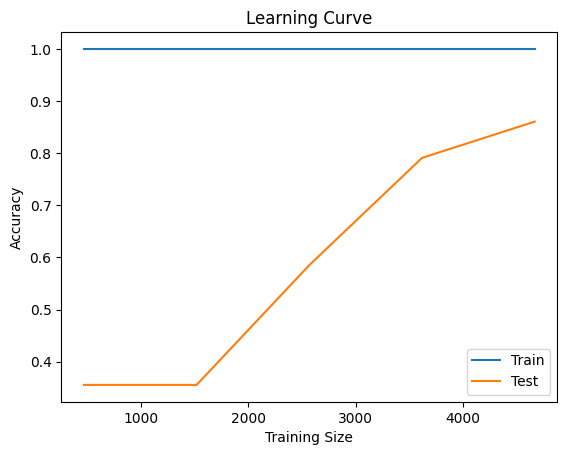

In [ ]:
# Plot learning curve to see if the model is overfitting training data
# Result: Clear overfitting!! Training accuracy does not increase as training set increases. Hyperparameter tuning needed.
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    rf_pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()

# RF predictor without tree-based selection

In [ ]:
# Trying RF predictor without tree-based feature selection to see if that's resulting in the model overfitting the training data
# All other transformers and parameters remain the same
rf_pipeline_2 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('variance', VarianceThreshold(threshold=0.01)), # removing constant and quasi constant features, first-pass
    ('select_kbest', SelectKBest(score_func=f_classif, k = 1000)), # filters top 1000 features by ANOVA F-score univariate test
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)) # accounting for class weights
],
                       verbose = True)

In [ ]:
rf_pipeline_2.fit(X_train, y_train)
y_train_pred = rf_pipeline_2.predict(X_train)
y_test_pred = rf_pipeline_2.predict(X_test)


# Performance metrics
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

[Pipeline] ..... (step 1 of 4) Processing preprocessing, total=   8.1s
[Pipeline] .......... (step 2 of 4) Processing variance, total=   2.0s
[Pipeline] ...... (step 3 of 4) Processing select_kbest, total=   2.9s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  17.7s
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3387
           1       1.00      1.00      1.00      1873

    accuracy                           1.00      5260
   macro avg       1.00      1.00      1.00      5260
weighted avg       1.00      1.00      1.00      5260

Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       377
           1       0.79      0.50      0.61       208

    accuracy                           0.78       585
   macro avg       0.78      0.71      0.73       585
weighted avg       0.78      0.78      0.76       585



In [ ]:
# Perform cross-validation on the same RF pipeline, based on class-stratified 5-fold CV which was defined when splitting train/test
cv_results = cross_validate(rf_pipeline_2, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 4) Processing preprocessing, total=   4.1s
[Pipeline] .......... (step 2 of 4) Processing variance, total=   2.0s
[Pipeline] ...... (step 3 of 4) Processing select_kbest, total=   2.5s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  21.0s
[Pipeline] ..... (step 1 of 4) Processing preprocessing, total=   5.7s
[Pipeline] .......... (step 2 of 4) Processing variance, total=   3.0s
[Pipeline] ...... (step 3 of 4) Processing select_kbest, total=   1.9s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  19.9s
[Pipeline] ..... (step 1 of 4) Processing preprocessing, total=   3.5s
[Pipeline] .......... (step 2 of 4) Processing variance, total=   1.6s
[Pipeline] ...... (step 3 of 4) Processing select_kbest, total=   1.2s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  26.3s
[Pipeline] ..... (step 1 of 4) Processing preprocessing, total=   4.4s
[Pipeline] .......... (step 2 of 4) Processing variance, total=   1.7s
[Pipel

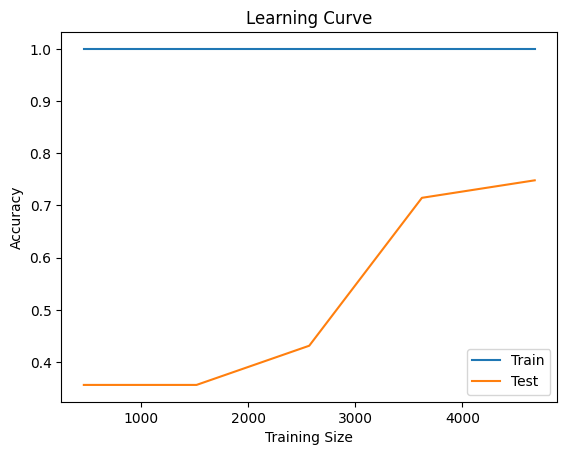

In [ ]:
# Plot learning curve to see if the model is overfitting training data
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
train_sizes, train_scores, test_scores = learning_curve(
    rf_pipeline_2, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()

Seems that the inclusion or exlcusion of a tree-based feature selection step has very little impact on RF overfitting to training data (precision/recall = 1.0 in training classification report for both).

In [ ]:
param_grid = {
    # number of trees
    'clf__n_estimators': [100, 200, 500],

    # limit tree depth (important to reduce overfitting)
    'clf__max_depth': [None, 10, 20, 30],

    # control minimum sampfles required at a leaf node
    'clf__min_samples_leaf': [1, 2, 5, 10],

    # control number of samples needed to split a node
    'clf__min_samples_split': [2, 5, 10]
}


# **RF Hyperparamter tuning**

In [ ]:
# trying out randomised search because this will take less time than GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from scipy.stats import randint

# 1) Define a hyperparameter “distribution” dictionary instead of a full grid.
#    For discrete options, we can use scipy.stats.randint or simply pass a Python list.
param_dist = {
    # number of trees: pick uniformly from [100, 500]
    'clf__n_estimators': randint(100, 500),

    # tree depth: either None, or an integer from 10 to 50
    # We'll encode "None" as 0, then map 0→None in a custom wrapper
    'clf__max_depth': [None] + list(range(10, 51, 10)),
    # (This is semidiscrete; randint doesn’t directly support None. We’ll rely on sampling from a list.)

    # min samples in leaf: 1–20
    'clf__min_samples_leaf': randint(1, 21),

    # min samples to split: 2–20
    'clf__min_samples_split': randint(2, 21),
}


In [ ]:
# 2) Wrap your entire pipeline (preprocessing→selectors→clf) in RandomizedSearchCV.
#    Let’s say we do 40 random draws, and each is validated via cv=3.
random_search = RandomizedSearchCV(
    estimator=rf_pipeline,        # your existing Pipeline, unchanged
    param_distributions=param_dist,
    n_iter=40,                    # try 40 random settings total
    scoring='accuracy',           # or whichever scoring you care about
    cv=3,                         # 3-fold inner CV for each random setting
    random_state=42,              # for reproducibility
    n_jobs=-1                     # parallelize across CPUs
)

# 3) Do a 5‐fold outer CV to get an unbiased estimate of performance:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

nested_scores = cross_val_score(
    random_search,
    X, y,
    cv=outer_cv,
    scoring='accuracy',
    n_jobs=-1
)
print(f"Nested CV accuracy (randomized inner search): {nested_scores.mean():.4f} ± {nested_scores.std():.4f}")

Nested CV accuracy (randomized inner search): 0.8736 ± 0.0148


In [ ]:
# 1) Instantiate another RandomizedSearchCV with the same param_dist and n_iter
final_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=40,
    scoring='accuracy',
    cv=3,         # you can use a slightly larger CV here since you’re not in an outer loop
    random_state=42,
    n_jobs=-1
)
# 2) Fit on all X, y
final_random_search.fit(X, y)

# 3) Inspect your best hyperparameters & CV score
print("Best parameters found:", final_random_search.best_params_)
print("Best CV accuracy (inner folds):", final_random_search.best_score_)

# 4) Grab the “best estimator” (pipeline with best parameters baked in)
best_pipeline = final_random_search.best_estimator_

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   6.4s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   2.0s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   2.3s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   9.2s
Best parameters found: {'clf__max_depth': 30, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 6, 'clf__n_estimators': 406}
Best CV accuracy (inner folds): 0.8105542860450798


In [ ]:
# final RF model with tuned parameters:
tuned_rf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('variance', VarianceThreshold(threshold=0.01)), # removing constant and quasi constant features, first-pass
    ('select_kbest', SelectKBest(score_func=f_classif, k = 1000)), # filters top 500 features by ANOVA F-score univariate test
    ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced', max_features= 100))), # tree-based feature selection
    ('clf', RandomForestClassifier(n_estimators=406, class_weight='balanced', random_state=42,
                                   max_depth= 10, min_samples_leaf = 3, min_samples_split = 6)) # accounting for class weights
],
                       verbose = True)

In [ ]:
# Fit pipeline to training data - click each step in the figure below to see the parameters for each step
tuned_rf_pipeline.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   5.8s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.5s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.7s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  14.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  11.3s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gc_content',
                                                   'theoretical_pi', 'Tiny',
                                                   'Small', 'Aliphatic',
                                                   'Aromatic', 'Non.polar',
                                                   'Polar', 'Charged', 'Basic',
                                                   'Acidic', 'Twist.lag1',
                                                   'Twist.lag2', 'Tilt.lag1',
                                                   'Tilt.lag2',
                                                   'Twist.Tilt.lag.1',
                                                   'Twist.Tilt.lag.2',...
                                                  ['Signals'])])),
                ('variance', VarianceThreshold(threshold=0.01)),
                ('select_kbest', SelectKBest(k=1000)),
                ('select_model',
                 SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced',
                                                                max_features=100))),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=3, min_samples_split=6,
                                        n_estimators=406, random_state=42))],
         verbose=True)

In [ ]:
# Apply to testing set
from sklearn.metrics import classification_report, confusion_matrix
y_train_pred = tuned_rf_pipeline.predict(X_train)
y_test_pred = tuned_rf_pipeline.predict(X_test)

# Performance metrics
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3387
           1       0.86      0.99      0.92      1868

    accuracy                           0.94      5255
   macro avg       0.93      0.95      0.94      5255
weighted avg       0.95      0.94      0.94      5255

Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       376
           1       0.75      0.88      0.81       208

    accuracy                           0.86       584
   macro avg       0.84      0.86      0.85       584
weighted avg       0.87      0.86      0.86       584



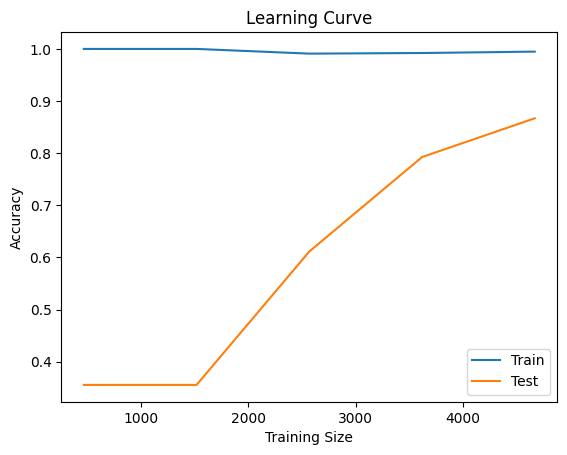

In [ ]:
# Learning curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
train_sizes, train_scores, test_scores = learning_curve(
    tuned_rf_pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()

In [ ]:
# still quite bad even after hyperparameter tuning. better but not great.

# **Tuning feature selection**

In [ ]:
param_grid = {
    # Tune the variance‐filter cutoff:
    "variance__threshold": [0.0, 0.001, 0.005, 0.01, 0.05],

    # (… plus whatever you’re already tuning in SelectKBest / SelectFromModel / RF …)
    "select_kbest__k": [200, 500, 1000],
    "select_model__max_features": [50, 100, 200]
}

In [ ]:
grid = GridSearchCV(
    estimator= rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2,
)
grid.fit(X_train, y_train)

print("Best threshold:", grid.best_params_["variance__threshold"])
print("Best CV score:", grid.best_score_)
print("Best kbest k:", grid.best_params_["select_kbest__k"])
print("Best model max features:", grid.best_params_["select_model__max_features"])

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.6s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.5s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   2.5s
Best threshold: 0.01
Best CV score: 0.8630159480094912


Best kbest k: 1000
Best model max features: 100


# Features retained after feature selection

In [ ]:
# ─── 2) Grab the Boolean masks at each selection step ──────────────────────────

# 2a) After VarianceThreshold
var_selector = tuned_rf_pipeline.named_steps["variance"]
var_mask = var_selector.get_support()
n_after_variance = var_mask.sum()
print("Features after VarianceThreshold:", n_after_variance)

# 2b) After SelectKBest
kbest_selector = tuned_rf_pipeline.named_steps["select_kbest"]
kbest_mask = kbest_selector.get_support()
n_after_kbest = kbest_mask.sum()
print("Features after SelectKBest:", n_after_kbest)

# 2c) After SelectFromModel
model_selector = tuned_rf_pipeline.named_steps["select_model"]
model_mask = model_selector.get_support()
n_after_selectfrommodel = model_mask.sum()
print("Features after SelectFromModel:", n_after_selectfrommodel)

Features after VarianceThreshold: 10293
Features after SelectKBest: 1000
Features after SelectFromModel: 84


In [ ]:
# ─── 3) Recover “feature names” at each stage ───────────────────────────────────

# 3a) Get the names of all features *after* preprocessing:
#     If `preprocessor` is a ColumnTransformer or something with get_feature_names_out(), you can do:
pre_names = tuned_rf_pipeline.named_steps["preprocessing"] \
                 .get_feature_names_out(X_train.columns)
#
#    - If your preprocessor was built with a ColumnTransformer + OneHotEncoder or SimpleImputer + scaler,
#      get_feature_names_out(...) will give you e.g. ["gene_length", "gc_content", "ppm_degree_0", "ppm_degree_1", ...].
#    - If your preprocessing step doesn’t have get_feature_names_out, you’ll need to construct this list manually in the same order that `preprocessor` applied them.

# 3b) Which of those “preprocessed” names survived variance filtering?
names_after_variance = np.array(pre_names)[var_mask]

# 3c) Which of *those* survived SelectKBest?
names_after_kbest = names_after_variance[kbest_mask]

# 3d) Which of *those* survived SelectFromModel?
final_feature_names = names_after_kbest[model_mask]

In [ ]:
print("\nExample of names after VarianceThreshold (first 10):")
print(names_after_variance[:10])

print("\nExample of names after SelectKBest (first 10):")
print(names_after_kbest[:10])

print("\nFinal selected features (first 10):")
print(final_feature_names[:10])



Example of names after VarianceThreshold (first 10):
['num__gc_content' 'num__theoretical_pi' 'num__Tiny' 'num__Small'
 'num__Aliphatic' 'num__Aromatic' 'num__Non.polar' 'num__Polar'
 'num__Charged' 'num__Basic']

Example of names after SelectKBest (first 10):
['num__gc_content' 'num__Aliphatic' 'num__Aromatic' 'num__Non.polar'
 'num__Polar' 'num__Twist.lag2' 'num__Tilt.lag1' 'num__Tilt.lag2'
 'num__Twist.Tilt.lag.2' 'num__Tilt.Twist.lag.2']

Final selected features (first 10):
['num__Aliphatic' 'num__Aromatic' 'num__Non.polar' 'num__Polar'
 'num__Xc1.AG' 'num__VS163' 'num__transcript_length'
 'num__transcript_count' 'num__is_constitutive' 'num__Num_Isoforms']


In [ ]:
names_after_kbest

array(['num__gc_content', 'num__Aliphatic', 'num__Aromatic',
       'num__Non.polar', 'num__Polar', 'num__Twist.lag2',
       'num__Tilt.lag1', 'num__Tilt.lag2', 'num__Twist.Tilt.lag.2',
       'num__Tilt.Twist.lag.2', 'num__Nucleosome.lag1',
       'num__Nucleosome.lag2', 'num__AA_x', 'num__AC_x', 'num__AG_x',
       'num__AT_x', 'num__CA_x', 'num__CC_x', 'num__CG_x', 'num__CT_x',
       'num__GA_x', 'num__GC_x', 'num__GG_x', 'num__GT_x', 'num__TA_x',
       'num__TC_x', 'num__TG_x', 'num__TT_x', 'num__Xc1.AC',
       'num__Xc1.AG', 'num__Xc1.AT', 'num__Xc1.CA', 'num__Xc1.CG',
       'num__Xc1.CT', 'num__Xc1.GC', 'num__Xc1.GT', 'num__Xc1.TA',
       'num__Xc1.TC', 'num__Xc1.TG', 'num__Xc1.TT', 'num__Xc2.lambda.3_x',
       'num__Xc1.AAC', 'num__Xc1.AAT', 'num__Xc1.ACA', 'num__Xc1.ACG',
       'num__Xc1.ACT', 'num__Xc1.AGA', 'num__Xc1.AGC', 'num__Xc1.AGT',
       'num__Xc1.ATA', 'num__Xc1.ATG', 'num__Xc1.ATT', 'num__Xc1.CAA',
       'num__Xc1.CAC', 'num__Xc1.CAG', 'num__Xc1.CCG', 'num_

In [ ]:
#inspect final feature names
final_feature_names

array(['num__Aliphatic', 'num__Aromatic', 'num__Non.polar', 'num__Polar',
       'num__Xc1.AG', 'num__VS163', 'num__transcript_length',
       'num__transcript_count', 'num__is_constitutive',
       'num__Num_Isoforms', 'num__exon_chrom_length',
       'num__biological_process', 'num__cellular_component',
       'num__molecular_function', 'num__p_Cytoplasm', 'num__p_Nucleus',
       'num__p_Extracellular', 'num__residues_inside',
       'num__para_median_diopt_score', 'num__para_max_diopt_score',
       'num__Fission yeast_Ortholog_Count',
       'num__Mosquito_Ortholog_Count', 'num__Rat_Ortholog_Count',
       'num__Western clawed frog_Ortholog_Count', 'num__ortho_mean_diopt',
       'num__ortho_median_diopt', 'num__ortho_max_diopt',
       'num__Fly_Fission yeast_AvgDIOPT', 'num__Fly_Mosquito_AvgDIOPT',
       'num__Fly_Rat_AvgDIOPT', 'num__Fly_Thale cress_AvgDIOPT',
       'num__Fly_Worm_AvgDIOPT', 'num__Fly_Yeast_AvgDIOPT',
       'num__High_Rank_Ortholog_Count',
       'num__high_

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Final 84 feature counts by category
final_counts = {
    "Gene Expression": 24,
    "Gene Ontology":   19,
    "Evolution":       17,
    "PPI Network":     7,
    "Subcellular Loc": 6,
    "Gene Sequence":   5,
    "Protein Seq":     5,
    "Domains":         1
}

# Define intrinsic vs. extrinsic
intrinsic_categories = ["Gene Sequence", "Protein Seq"]
extrinsic_categories = [cat for cat in final_counts if cat not in intrinsic_categories]

# Build DataFrame
data = pd.DataFrame([
    {
        "Category": cat,
        "Count": cnt,
        "Type": "Intrinsic" if cat in intrinsic_categories else "Extrinsic"
    }
    for cat, cnt in final_counts.items()
])

# Sort by count descending (so bars appear in that order)
data = data.sort_values("Count", ascending=False).reset_index(drop=True)

# Prepare a custom color for each category: two greens, six blues
green_cmap = cm.get_cmap("Greens", len(intrinsic_categories) + 1)
blue_cmap = cm.get_cmap("Blues", len(extrinsic_categories) + 2)

intrinsic_colors = {
    intrinsic_categories[i]: green_cmap(i + 2)
    for i in range(len(intrinsic_categories))
}
extrinsic_colors = {
    extrinsic_categories[i]: blue_cmap(i + 2)
    for i in range(len(extrinsic_categories))
}
category_colors = {**intrinsic_colors, **extrinsic_colors}

# Add a column for color
data["Color"] = data["Category"].map(category_colors)

# Set Seaborn style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6), dpi=1000)

ax = plt.gca()

# Light grey horizontal grid lines
ax.grid(axis="y", color="lightgrey", linewidth=0.7)
sns.despine(left=False, bottom=False, right=True, top=True)

# Plot bars manually so we can assign each a custom color
bars = ax.bar(
    x=np.arange(len(data)),
    height=data["Count"],
    color=data["Color"],
    edgecolor="black"
)

# Annotate each bar with "n = X"
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + 0.5,
        f"n = {int(h)}",
        ha="center",
        va="bottom",
        fontsize=10,
        color="black"
    )

# Labels and title in black
ax.set_xlabel("Feature Category", fontsize=12, color="black")
ax.set_ylabel("Number of Features", fontsize=12, color="black")
ax.set_title("Distribution of Selected Features by Category\n(Intrinsic vs. Extrinsic)", fontsize=14, color="black")

# X‐tick labels rotated and colored black
ax.set_xticks(np.arange(len(data)))
ax.set_xticklabels(data["Category"], rotation=45, ha="right", fontsize=10, color="black")

# Create custom legend patches
from matplotlib.lines import Line2D
intr_patch = Line2D([0], [0], marker="s", color=intrinsic_colors[intrinsic_categories[0]],
                    linestyle="", markersize=10, label="Intrinsic")
extr_patch = Line2D([0], [0], marker="s", color=extrinsic_colors[extrinsic_categories[2]],
                    linestyle="", markersize=10, label="Extrinsic")

legend = ax.legend(handles=[intr_patch, extr_patch], fontsize=12, title="", loc="upper right")
legend.get_frame().set_facecolor("white")
for text in legend.get_texts():
    text.set_color("black")

plt.tight_layout()
plt.show()


<ipython-input-89-0bcbf813461d>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  green_cmap = cm.get_cmap("Greens", len(intrinsic_categories) + 1)
<ipython-input-89-0bcbf813461d>:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blue_cmap = cm.get_cmap("Blues", len(extrinsic_categories) + 2)


# **LOGISTIC REGRESSION**

In [ ]:
# Logistic regression pipeline
# (L2 regularisation for now because ElasticNet is taking very long to run - will try again?)
lr_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('variance', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(score_func=f_classif, k=500)),
        ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))),
        ('clf', LogisticRegression(penalty = 'l2', class_weight = 'balanced', random_state = 42, max_iter = 5000))
    ],
                    verbose = True)

lr_pipeline.fit(X_train, y_train)
# Train set performance
y_train_pred = lr_pipeline.predict(X_train)
print("LR Train Classification Report:\n", classification_report(y_train, y_train_pred))

# Test set performance
y_test_pred = lr_pipeline.predict(X_test)
print("LR Test Classification Report:\n", classification_report(y_test, y_test_pred))

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.0s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.5s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s
LR Train Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      3387
           1       0.65      0.71      0.68      1868

    accuracy                           0.76      5255
   macro avg       0.74      0.75      0.75      5255
weighted avg       0.77      0.76      0.76      5255

LR Test Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.80       376
           1       0.63      0.65      0.64       208

    accuracy                           0.74       584
   macro avg       0.72      0.72  

In [ ]:
cv_results = cross_validate(lr_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   2.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   6.2s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.5s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   5.3s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   3.9s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   5.4s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.5s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   5.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.4s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.1s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   4.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.6s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.1s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.2s
Cross-validation scores:  [0.76113014 0.74657534 0.74828767 0.76712329 0.75921165]
Mean CV accuracy: 0.7565
Standard deviation of CV accuracy: 0.0078


**Logistic regression performs better than DummyClassifier when model is trainined on both intrinsic and extrinsic features (CV accuracy = 0.75), but worse when trained on ininstric featurs alone (CV accuracy = 0.625).**
- Hyperparameters have not been tuned
- Tree-based feature selection method has been applied to a linear model (non-linear features fit to a linear model)

LR still performs really poorly even with ElasticNet regularisation. Can try hyperparameter tuning with LogisticRegressionCV, but this will take forever to compute, so do it later!

# **SUPPORT VECTOR MACHINE (SVM)**

In [ ]:
# Support vector machine. Using default rbf kernel, but can change this to 'linear', 'poly', 'sigmoid' or 'precomputed'
svm_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('variance', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(score_func=f_classif, k=500)),
        ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))),
        ('clf', SVC(kernel = 'rbf', class_weight = 'balanced',probability = True, random_state = 42 ))
    ],
                    verbose = True)

svm_pipeline.fit(X_train, y_train)
# Train set performance
y_train_pred = svm_pipeline.predict(X_train)
print("SVM Train Classification Report:\n", classification_report(y_train, y_train_pred))

# Test set performance
y_test_pred = svm_pipeline.predict(X_test)
print("SVM Test Classification Report:\n", classification_report(y_test, y_test_pred))


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.0s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   9.1s
SVM Train Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      3387
           1       0.78      0.86      0.82      1868

    accuracy                           0.87      5255
   macro avg       0.85      0.86      0.86      5255
weighted avg       0.87      0.87      0.87      5255

SVM Test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       376
           1       0.73      0.73      0.73       208

    accuracy                           0.81       584
   macro avg       0.79      0.79

In [ ]:
cv_results = cross_validate(svm_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.1s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   6.6s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  11.3s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.3s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.2s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   6.4s
Cross-validation scores:  [0.81934932 0.79109589 0.79708904 0.80907534 0.80976864]
Mean CV accuracy: 0.8053
Standard deviation of CV accuracy: 0.0100


**SVM shows improved CV accuracy when trained on both extrinsic and intrinsic features (CV Accuracy = 0.806), compared to intrinisic features alone (CV Accuracy = 0.709)**

**Note, I'm using a tree-based feature selection method here which may be why the prediction accuracy for LR and SVM is low** -- nonlinear feature selection for a linear model. Feature selection should be LR and LinearSVC for LR and SVM, respectively, but I can't change this between classifiers if I want to do a fair comparison. Need to look at a model-agnostic feature selection method. However, I can continue to use ExtraTreeClassifier as my model for feature selection for all classifiers and perform hyperparameter tuning after

# **GRADIENT BOOSTING CLASSIFIER**

In [ ]:
# Gradient Boosting Classifier
# Default 'log_loss' is used, which refers to binomial and multinomial deviance - same as what is used for logistic regression
gbm_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('variance', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(score_func=f_classif, k=500)),
        ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))),
        ('clf', GradientBoostingClassifier(n_estimators = 100, loss = 'log_loss', random_state = 42))
    ],
                    verbose = True)

gbm_pipeline.fit(X_train, y_train)

# Train set performance
y_train_pred = gbm_pipeline.predict(X_train)
print("GBM Train Classification Report:\n", classification_report(y_train, y_train_pred))

# Test set performance
y_test_pred = gbm_pipeline.predict(X_test)
print("GBM Test Classification Report:\n", classification_report(y_test, y_test_pred))

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.4s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.6s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   7.7s
GBM Train Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      3387
           1       0.90      0.90      0.90      1868

    accuracy                           0.93      5255
   macro avg       0.92      0.92      0.92      5255
weighted avg       0.93      0.93      0.93      5255

GBM Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       376
           1       0.82      0.81      0.82       208

    accuracy                           0.87       584
   macro avg       0.86      0.86

In [ ]:
cv_results = cross_validate(gbm_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   6.6s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   7.8s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.3s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.7s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   2.5s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.3s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   6.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   6.9s
Cross-validation scores:  [0.89126712 0.8630137  0.87414384 0.88013699 0.87574979]
Mean CV accuracy: 0.8769
Standard deviation of CV accuracy: 0.0092


# **XTREME GRADIENT BOOSTING (XGB)**

In [ ]:
# XGBoost
xgb_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('variance', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(score_func=f_classif, k=500)),
        ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))),
        ('clf', XGBClassifier(n_estimators = 100, eval_metric = 'logloss',
                              scale_pos_weight = 1, random_state = 42))
    ],
                    verbose = True)

xgb_pipeline.fit(X_train, y_train)

# Train set performance
y_train_pred = xgb_pipeline.predict(X_train)
print("XGB Train Classification Report:\n", classification_report(y_train, y_train_pred))

# Test set performance
y_test_pred = xgb_pipeline.predict(X_test)
print("XGB Test Classification Report:\n", classification_report(y_test, y_test_pred))

NameError: name 'Pipeline' is not defined

In [ ]:
cv_results = cross_validate(xgb_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

# **MULTI-LAYER PERCEPTRON (MLP) CLASSIFIER**

In [ ]:
# MLPClassifier - Multi-layer Perceptron classifier (Neural network)
# can try out different parameters
mlp_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('variance', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(score_func=f_classif, k=500)),
        ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))),
        ('clf', MLPClassifier(hidden_layer_sizes=(100,),       # Single hidden layer with 100 neurons - a good starting point
        activation='relu',               # ReLU is standard for hidden layers; speeds up training and avoids vanishing gradients
        solver='adam',                   # Adam optimizer handles sparse gradients and noisy data well
        learning_rate='adaptive',       # Adjust learning rate during training if no improvement, helps convergence
        max_iter=300,
        random_state=42,
        early_stopping=True,            # Automatically stops training if validation score doesn't improve to prevent overfitting
        n_iter_no_change=10))
    ],
                    verbose = True)

mlp_pipeline.fit(X_train, y_train)

# Train set performance
y_train_pred = mlp_pipeline.predict(X_train)
print("MLP Train Classification Report:\n", classification_report(y_train, y_train_pred))

# Test set performance
y_test_pred = mlp_pipeline.predict(X_test)
print("MLP Test Classification Report:\n", classification_report(y_test, y_test_pred))

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.3s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   5.4s
MLP Train Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      3387
           1       0.87      0.84      0.86      1868

    accuracy                           0.90      5255
   macro avg       0.89      0.89      0.89      5255
weighted avg       0.90      0.90      0.90      5255

MLP Test Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88       376
           1       0.81      0.70      0.75       208

    accuracy                           0.83       584
   macro avg       0.83      0.80

In [ ]:
cv_results = cross_validate(mlp_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   3.9s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   1.1s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.0s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.4s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   1.1s
Cross-validation scores:  [0.82705479 0.80565068 0.79708904 0.82277397 0.80205656]
Mean CV accuracy: 0.8109
Standard deviation of CV accuracy: 0.0118


# **Visualise performance**

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

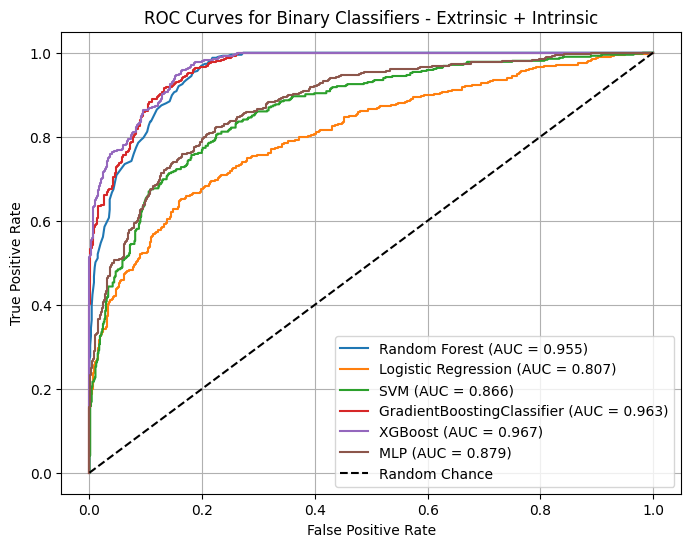

In [ ]:
# ROC-AUC (Receiver Operating Characteristic - Area Under Curve) measures the trade-off between True Positive Rate and False Positive Rate across
# thresholds. It's useful for balanced classes and provides an overall sense of model discrimination.

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Create dictionary of all fitted models
models = {
    'Random Forest': tuned_rf_pipeline,
    'Logistic Regression': lr_pipeline,
    'SVM': svm_pipeline,
    'GradientBoostingClassifier': gbm_pipeline,
    'XGBoost': xgb_pipeline,
    'MLP': mlp_pipeline,
}

plt.figure(figsize=(8, 6))

# Compute ROC-AUC curve iteratively for each model
for name, model in models.items():
    # Get predicted probabilities for the positive class (usually class 1)
    y_proba = model.predict_proba(X_test)[:, 1]

    #  ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # AUC
    auc_score = roc_auc_score(y_test, y_proba)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

# Plot diagonal chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Binary Classifiers - Extrinsic + Intrinsic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

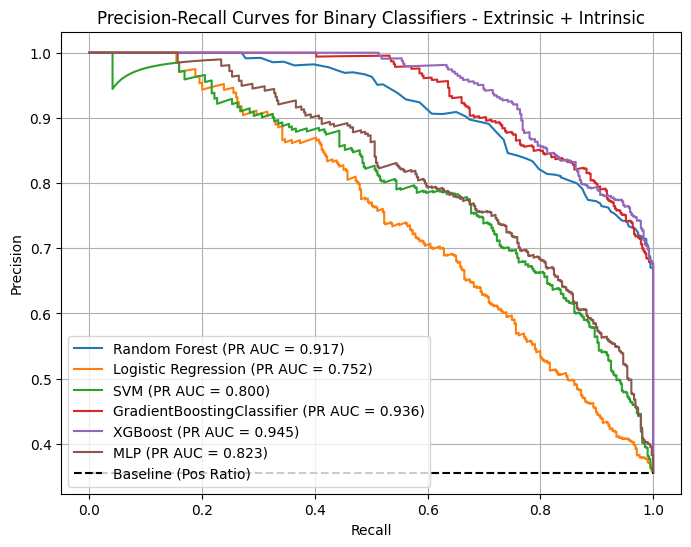

In [ ]:
# The overall essential vs non-essential classes aren't too imbalanced (1: 1.8), but the specific phenotypes (ie lethal/sterile dom/rec) will be.
# so need to consider PR-AUC curves. PR-AUC (Precision-Recall Area Under Curve) focuses on the trade-off between Precision and Recall.
# It shows how well the model identifies positive cases without too many false positives, so works better for imbalanced datasets.

from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Predicted probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    # PR-AUC score
    pr_auc_score = average_precision_score(y_test, y_proba)

    # Plot PR curve (recall on x-axis, precision on y-axis)
    plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc_score:.3f})")

# Baseline for PR curve = positive class ratio (horizontal line)
pos_ratio = sum(y_test) / len(y_test)
plt.plot([0, 1], [pos_ratio, pos_ratio], 'k--', label='Baseline (Pos Ratio)')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Binary Classifiers - Extrinsic + Intrinsic')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.6s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.8s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.7s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.2s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.3s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.7s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.9s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   8.7s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   7.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   8.4s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.4s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   8.8s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.6s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.4s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.7s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.2s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   7.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.7s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.9s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   6.9s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  10.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  10.3s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  10.7s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   9.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  10.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  11.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  10.7s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  10.9s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  12.1s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.8s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  10.9s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.7s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   9.8s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   9.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  10.9s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   9.9s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   9.8s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.8s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   8.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.3s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   9.3s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   9.3s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.8s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.1s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   8.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.4s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  10.2s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.9s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.9s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.8s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.3s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.9s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   3.3s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.8s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.8s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.9s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.3s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.0s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.0s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   3.1s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   5.1s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipel

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['inflammatory response'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.8s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.8s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.4s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   5.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['toxin activity'] will be ignored
  warnings.warn(


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   0.7s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   0.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   2.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   6.9s


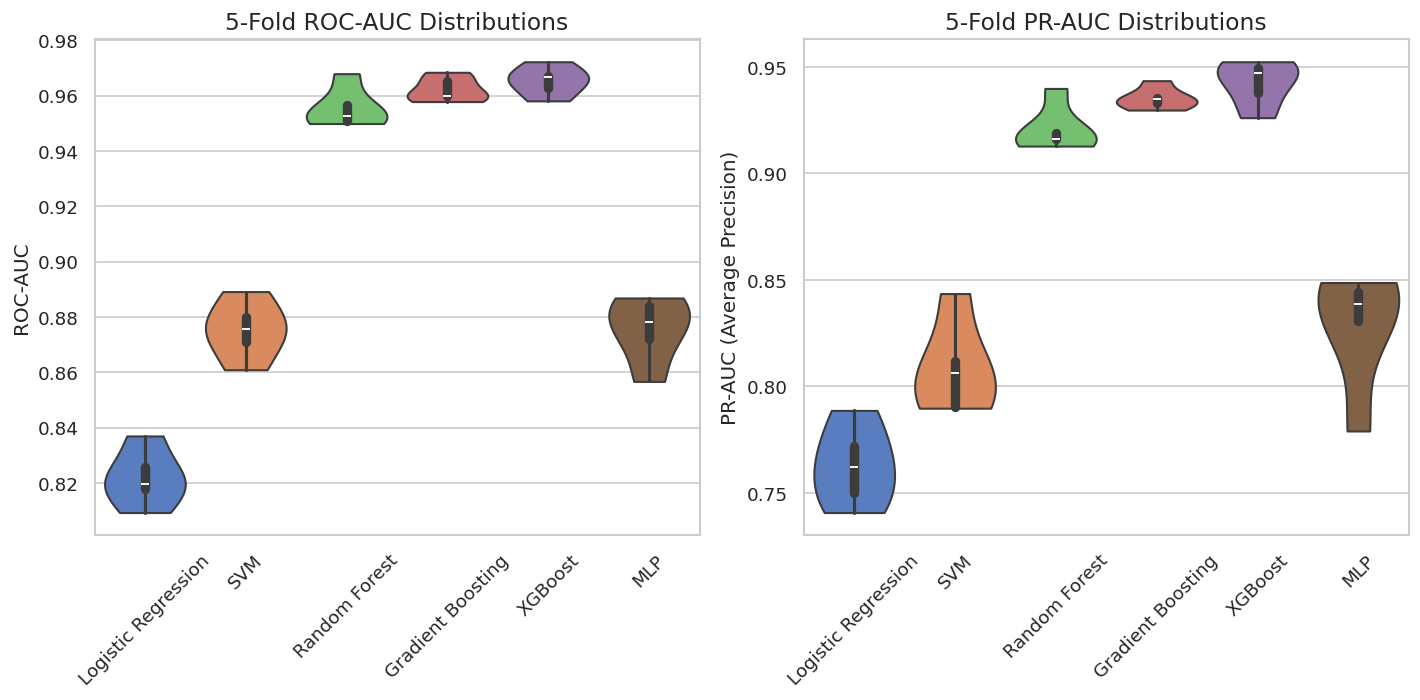

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold

# 1) Assume you already have your trained pipelines defined, for example:
#    tuned_rf_pipeline, lr_pipeline, svm_pipeline, gbm_pipeline, xgb_pipeline, mlp_pipeline

models = {
    "Logistic Regression": lr_pipeline,
    "SVM": svm_pipeline,
    "Random Forest": tuned_rf_pipeline,   # your RF pipeline (incl. preprocessing & feature selection)
    "Gradient Boosting": gbm_pipeline,
    "XGBoost": xgb_pipeline,
    "MLP": mlp_pipeline
}

# 2) Prepare a 5‐fold Stratified CV splitter (same as you used for hyperparameter tuning)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) For each model, compute 5‐fold ROC‐AUC and PR‐AUC (average_precision) scores
roc_scores = {}
pr_scores  = {}

for name, pipeline in models.items():
    # ROC‐AUC (use predict_proba internally)
    roc = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")
    # PR‐AUC (average_precision_score)
    pr  = cross_val_score(pipeline, X, y, cv=cv, scoring="average_precision")
    roc_scores[name] = roc
    pr_scores[name]  = pr

# 4) Build a DataFrame in “long” format for Seaborn
#    We’ll create one DataFrame for ROC and add a column “Metric” so we can plot side‐by‐side later.

# Helper to stack each model’s array into a long table
def stack_scores(score_dict, metric_name):
    """
    score_dict: {"ModelName": array_of_length_5, ...}
    metric_name: string, e.g. "ROC_AUC" or "PR_AUC"
    """
    rows = []
    for model_name, arr in score_dict.items():
        for fold_idx, val in enumerate(arr, start=1):
            rows.append({
                "Model": model_name,
                "Fold": fold_idx,
                metric_name: val
            })
    return pd.DataFrame(rows)

df_roc = stack_scores(roc_scores, "ROC_AUC")
df_pr  = stack_scores(pr_scores,  "PR_AUC")

# 5) Merge them into a single DataFrame (optional, if you want a single plot with hue=Metric)
df_roc["Metric"] = "ROC_AUC"
df_pr["Metric"]  = "PR_AUC"

# For side‐by‐side plotting, you can keep df_roc and df_pr separate, or concatenate:
df_all = pd.concat([df_roc, df_pr], axis=0, ignore_index=True)

# 6) Plot violin plots. We’ll do two subplots: left = ROC_AUC, right = PR_AUC.
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False, dpi=120)

# 6a) ROC‐AUC violin
sns.violinplot(
    x="Model",
    y="ROC_AUC",
    data=df_roc,
    inner="box",        # draw the box‐plot inside the violin
    cut=0,              # do not extend beyond the data extremes
    scale="width",      # each violin has same maximum width
    palette="muted",
    ax=axes[0]
)
axes[0].set_title("5-Fold ROC-AUC Distributions", fontsize=14)
axes[0].set_xlabel("")
axes[0].set_ylabel("ROC-AUC", fontsize=12)
axes[0].tick_params(axis="x", rotation=45)

# 6b) PR-AUC violin
sns.violinplot(
    x="Model",
    y="PR_AUC",
    data=df_pr,
    inner="box",
    cut=0,
    scale="width",
    palette="muted",
    ax=axes[1]
)
axes[1].set_title("5-Fold PR-AUC Distributions", fontsize=14)
axes[1].set_xlabel("")
axes[1].set_ylabel("PR-AUC (Average Precision)", fontsize=12)
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


<ipython-input-61-ababd8a73449>:12: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.violinplot(
<ipython-input-61-ababd8a73449>:28: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.violinplot(


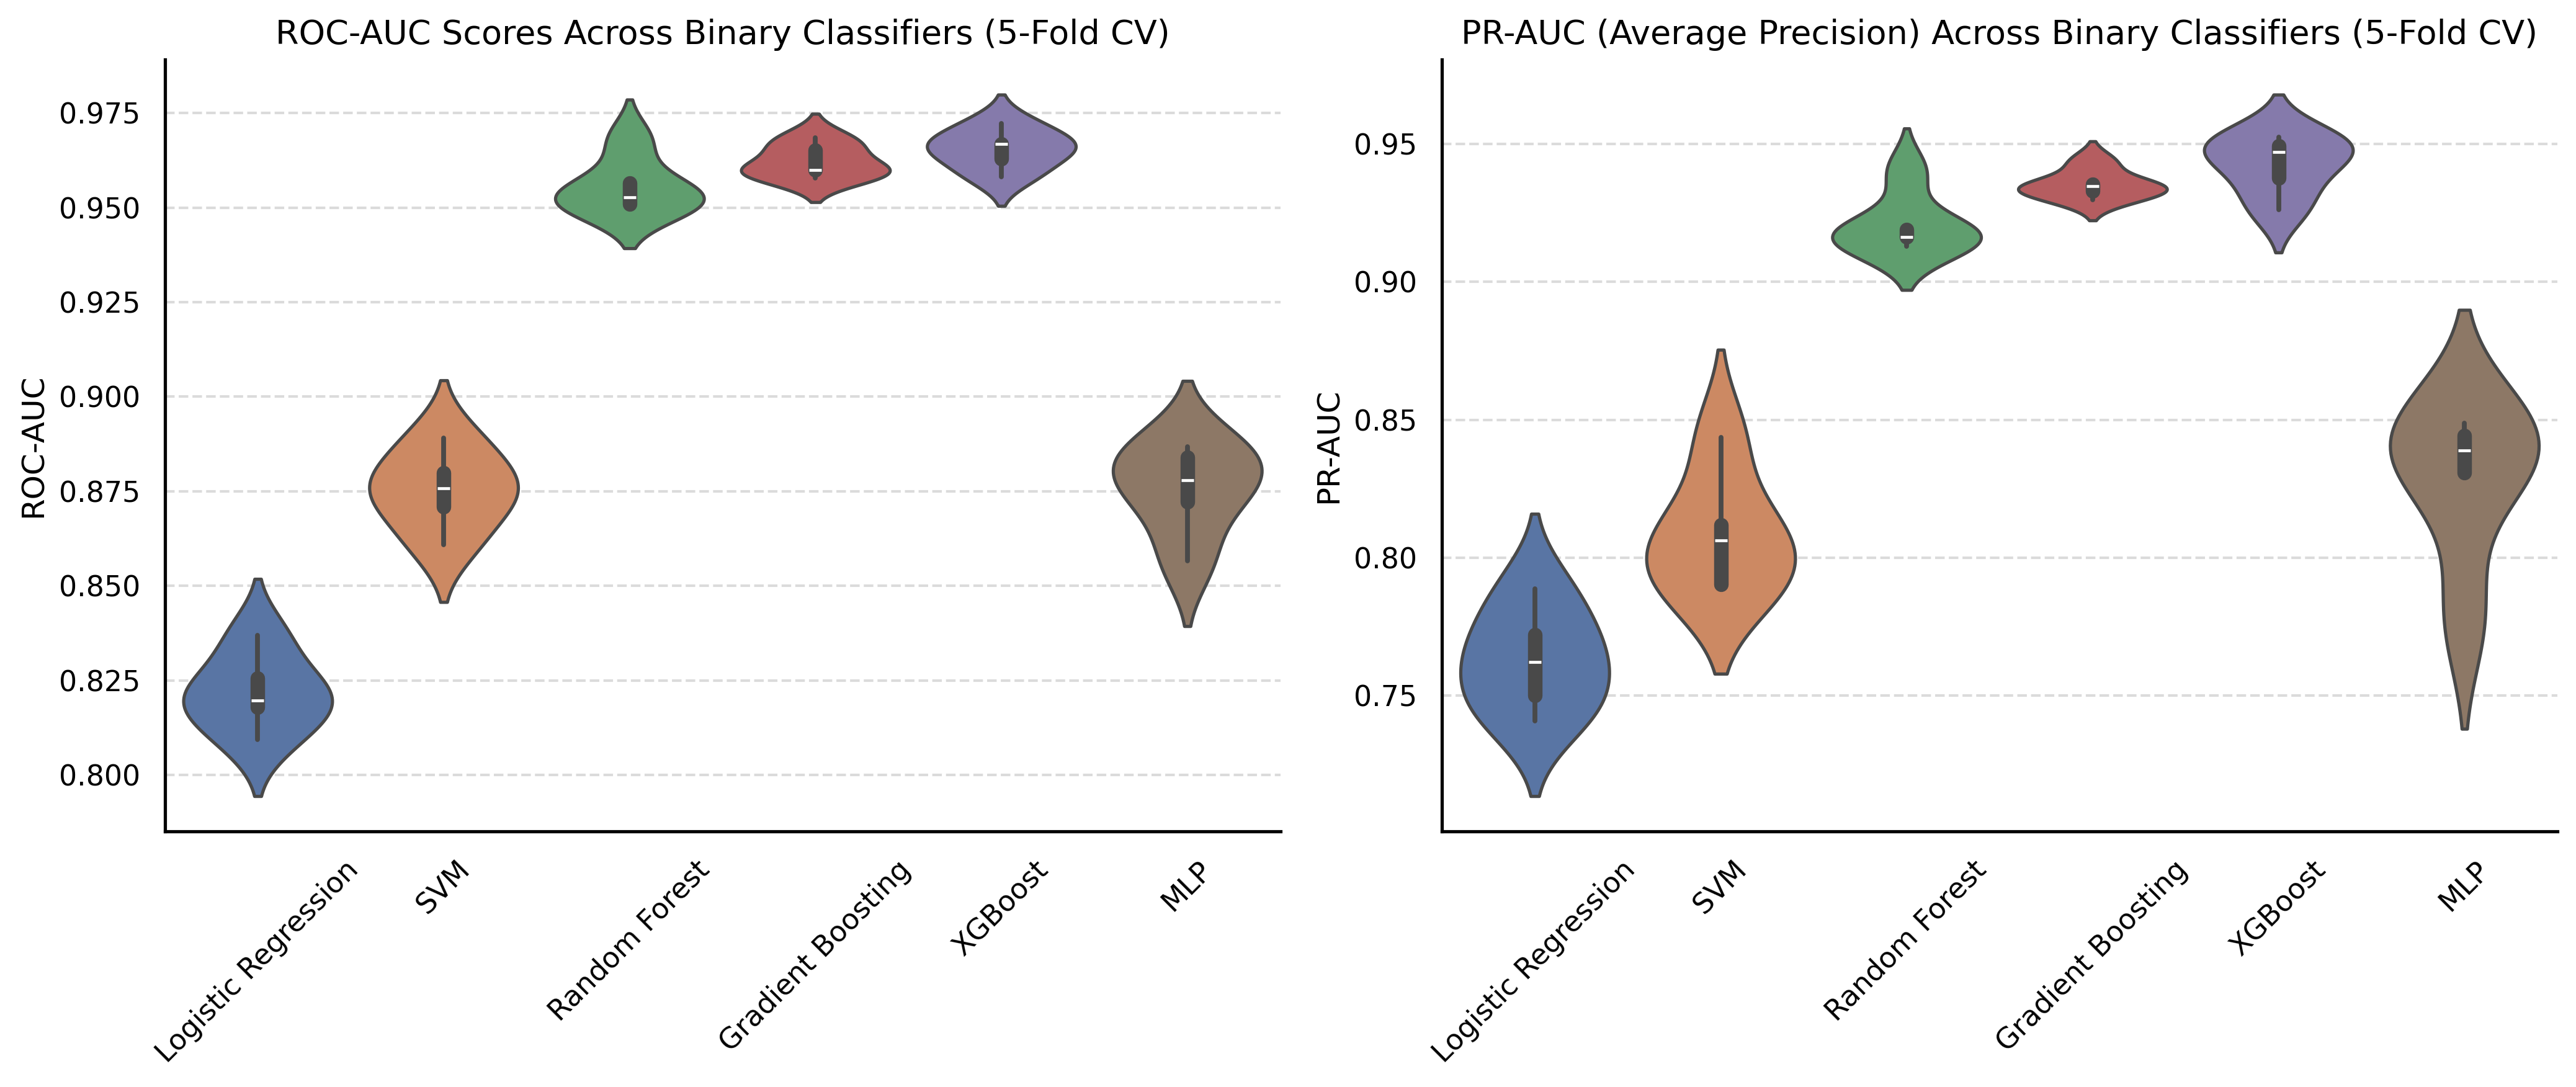

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="notebook", rc={"text.color": "black", "axes.labelcolor": "black", "xtick.color": "black", "ytick.color": "black", "axes.edgecolor": "black"})

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

# Define a clear, color-safe palette
palette = sns.color_palette()

# ROC-AUC Violin Plot
sns.violinplot(
    x="Model",
    y="ROC_AUC",
    data=df_roc,
    inner="box",
    scale="width",
    palette=palette,
    ax=axes[0]
)
axes[0].set_title("ROC-AUC Scores Across Binary Classifiers (5-Fold CV)", fontsize=13, color='black')
axes[0].set_ylabel("ROC-AUC", fontsize=12, color='black')
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=45, labelcolor='black')
axes[0].grid(True, axis="y", linestyle="--", alpha=0.7)

# PR-AUC Violin Plot
sns.violinplot(
    x="Model",
    y="PR_AUC",
    data=df_pr,
    inner="box",
    scale="width",
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("PR-AUC (Average Precision) Across Binary Classifiers (5-Fold CV)", fontsize=13, color='black')
axes[1].set_ylabel("PR-AUC", fontsize=12, color='black')
axes[1].set_xlabel("")
axes[1].tick_params(axis="x", rotation=45, labelcolor='black')
axes[1].grid(True, axis="y", linestyle="--", alpha=0.7)

# Clean up spines
for ax in axes:
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()


<ipython-input-54-0b5a9be8bc3f>:11: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.boxplot(
<ipython-input-54-0b5a9be8bc3f>:27: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.boxplot(


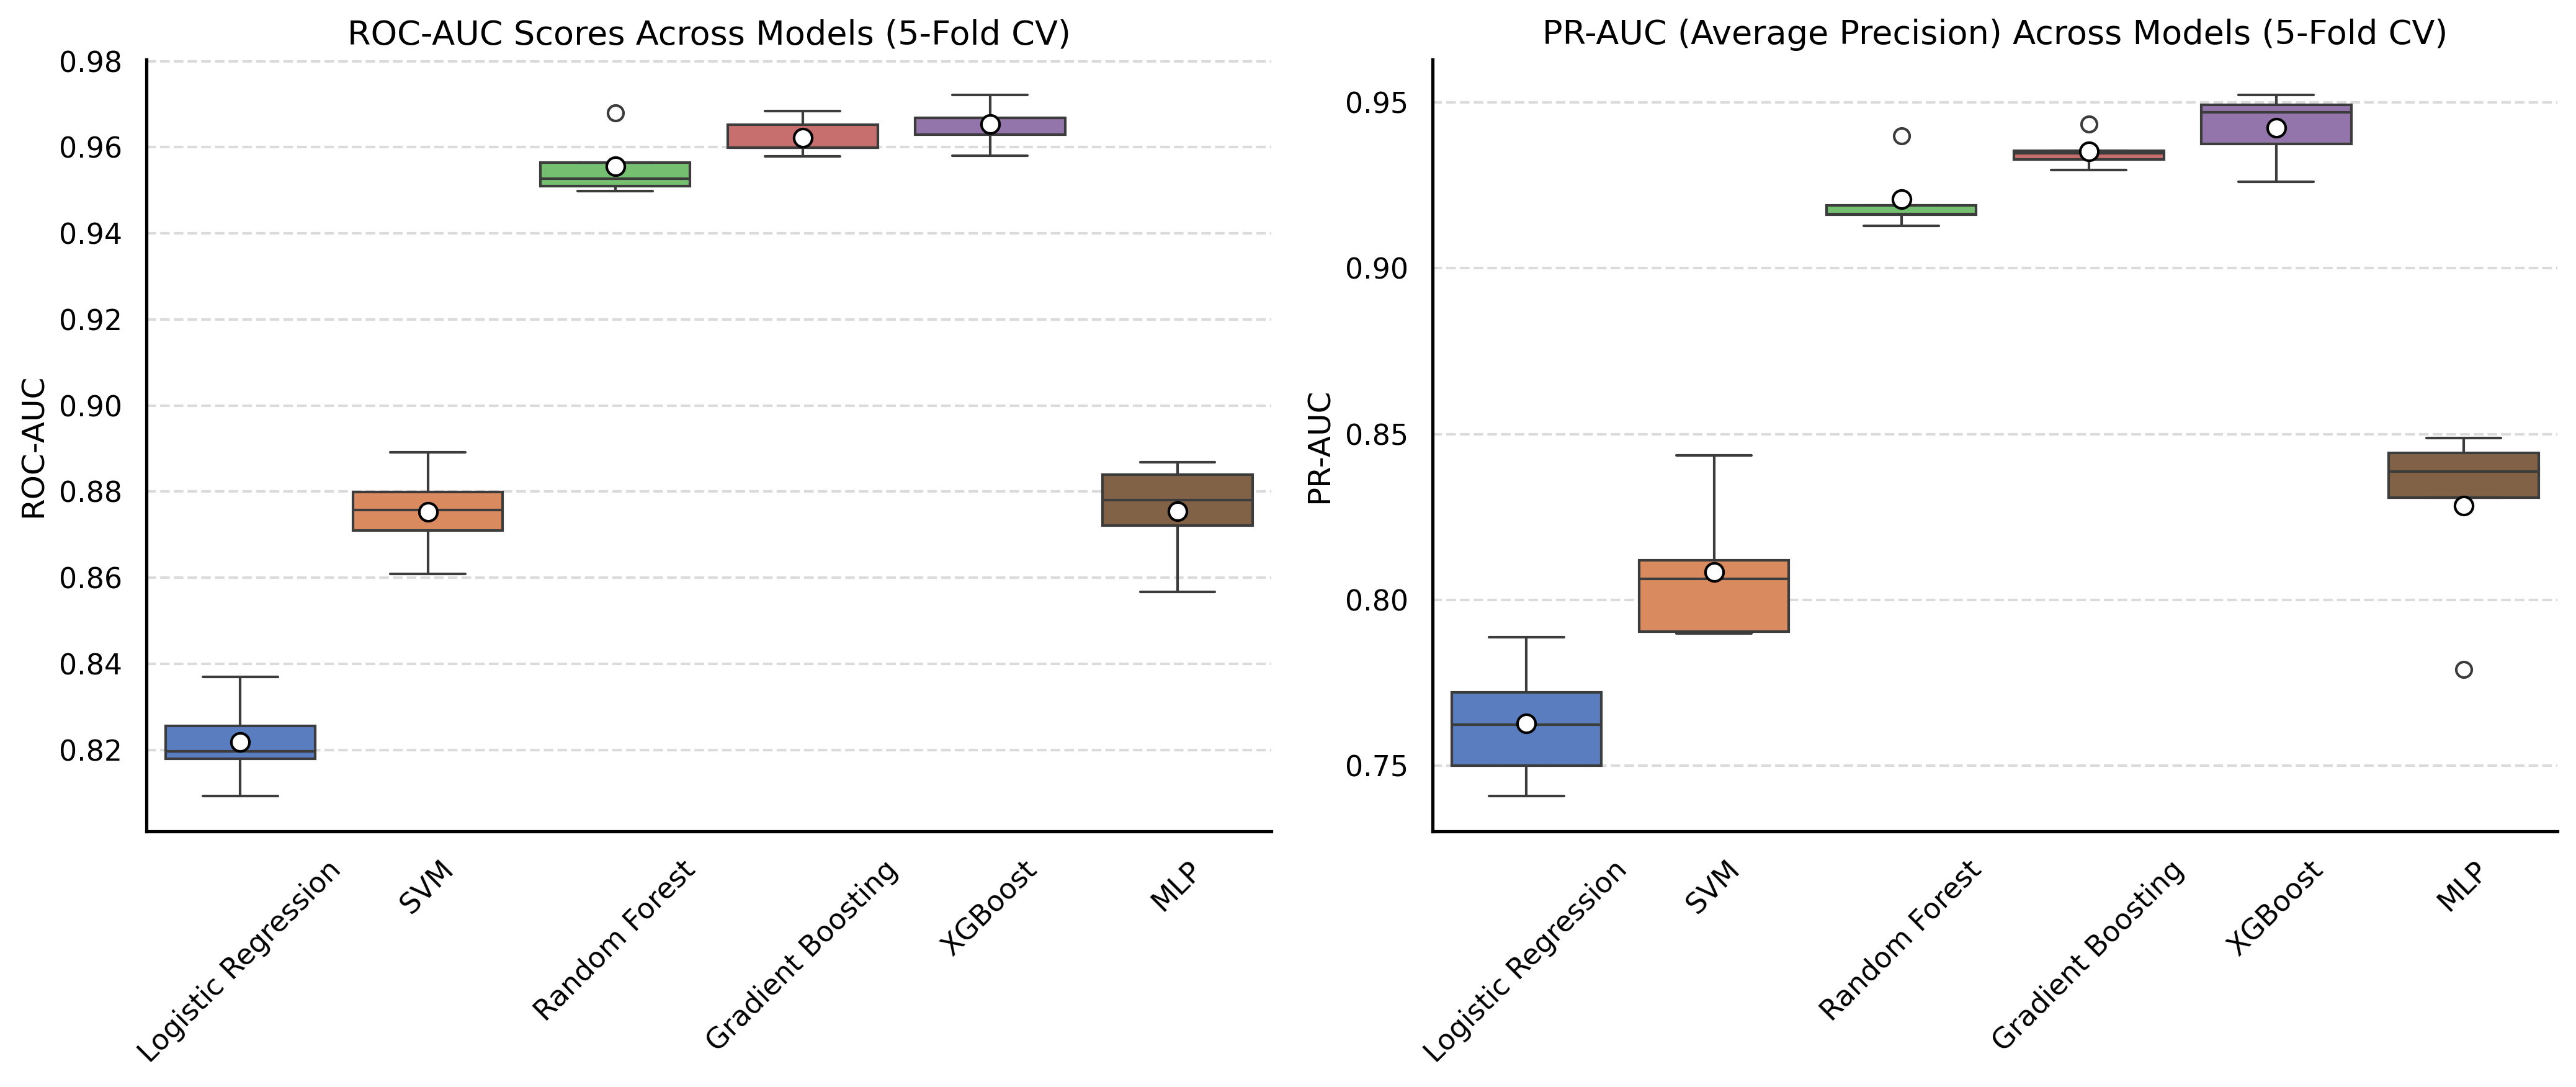

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="notebook", rc={"text.color": "black", "axes.labelcolor": "black", "xtick.color": "black", "ytick.color": "black", "axes.edgecolor": "black"})

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

palette = sns.color_palette("muted")

# ROC-AUC Boxplot
sns.boxplot(
    x="Model",
    y="ROC_AUC",
    data=df_roc,
    palette=palette,
    ax=axes[0],
    showmeans=True,      # show mean marker
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":7}
)
axes[0].set_title("ROC-AUC Scores Across Models (5-Fold CV)", fontsize=13, color='black')
axes[0].set_ylabel("ROC-AUC", fontsize=12, color='black')
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=45, labelcolor='black')
axes[0].grid(True, axis="y", linestyle="--", alpha=0.7)

# PR-AUC Boxplot
sns.boxplot(
    x="Model",
    y="PR_AUC",
    data=df_pr,
    palette=palette,
    ax=axes[1],
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":7}
)
axes[1].set_title("PR-AUC (Average Precision) Across Models (5-Fold CV)", fontsize=13, color='black')
axes[1].set_ylabel("PR-AUC", fontsize=12, color='black')
axes[1].set_xlabel("")
axes[1].tick_params(axis="x", rotation=45, labelcolor='black')
axes[1].grid(True, axis="y", linestyle="--", alpha=0.7)

for ax in axes:
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()


In [ ]:
df_all

Model  Fold   ROC_AUC   Metric    PR_AUC
0   Logistic Regression     1  0.825552  ROC_AUC       NaN
1   Logistic Regression     2  0.817888  ROC_AUC       NaN
2   Logistic Regression     3  0.819600  ROC_AUC       NaN
3   Logistic Regression     4  0.836948  ROC_AUC       NaN
4   Logistic Regression     5  0.809260  ROC_AUC       NaN
5                   SVM     1  0.889148  ROC_AUC       NaN
6                   SVM     2  0.870945  ROC_AUC       NaN
7                   SVM     3  0.860900  ROC_AUC       NaN
8                   SVM     4  0.879844  ROC_AUC       NaN
9                   SVM     5  0.875747  ROC_AUC       NaN
10        Random Forest     1  0.967932  ROC_AUC       NaN
11        Random Forest     2  0.950937  ROC_AUC       NaN
12        Random Forest     3  0.949900  ROC_AUC       NaN
13        Random Forest     4  0.956537  ROC_AUC       NaN
14        Random Forest     5  0.952736  ROC_AUC       NaN
15    Gradient Boosting     1  0.968430  ROC_AUC       NaN
16    Gradient Boosting     2  0.957846  ROC_AUC       NaN
17    Gradient Boosting     3  0.959907  ROC_AUC       NaN
18    Gradient Boosting     4  0.965254  ROC_AUC       NaN
19    Gradient Boosting     5  0.959917  ROC_AUC       NaN
20              XGBoost     1  0.972247  ROC_AUC       NaN
21              XGBoost     2  0.962892  ROC_AUC       NaN
22              XGBoost     3  0.958099  ROC_AUC       NaN
23              XGBoost     4  0.966915  ROC_AUC       NaN
24              XGBoost     5  0.966874  ROC_AUC       NaN
25                  MLP     1  0.877973  ROC_AUC       NaN
26                  MLP     2  0.872113  ROC_AUC       NaN
27                  MLP     3  0.856673  ROC_AUC       NaN
28                  MLP     4  0.883941  ROC_AUC       NaN
29                  MLP     5  0.886843  ROC_AUC       NaN
30  Logistic Regression     1       NaN   PR_AUC  0.772046
31  Logistic Regression     2       NaN   PR_AUC  0.740742
32  Logistic Regression     3       NaN   PR_AUC  0.762253
33  Logistic Regression     4       NaN   PR_AUC  0.788693
34  Logistic Regression     5       NaN   PR_AUC  0.749937
35                  SVM     1       NaN   PR_AUC  0.843555
36                  SVM     2       NaN   PR_AUC  0.790290
37                  SVM     3       NaN   PR_AUC  0.789743
38                  SVM     4       NaN   PR_AUC  0.806293
39                  SVM     5       NaN   PR_AUC  0.811922
40        Random Forest     1       NaN   PR_AUC  0.939875
41        Random Forest     2       NaN   PR_AUC  0.912814
42        Random Forest     3       NaN   PR_AUC  0.916237
43        Random Forest     4       NaN   PR_AUC  0.918909
44        Random Forest     5       NaN   PR_AUC  0.916350
45    Gradient Boosting     1       NaN   PR_AUC  0.943519
46    Gradient Boosting     2       NaN   PR_AUC  0.929724
47    Gradient Boosting     3       NaN   PR_AUC  0.932815
48    Gradient Boosting     4       NaN   PR_AUC  0.934735
49    Gradient Boosting     5       NaN   PR_AUC  0.935463
50              XGBoost     1       NaN   PR_AUC  0.949272
51              XGBoost     2       NaN   PR_AUC  0.926140
52              XGBoost     3       NaN   PR_AUC  0.937569
53              XGBoost     4       NaN   PR_AUC  0.952405
54              XGBoost     5       NaN   PR_AUC  0.946981
55                  MLP     1       NaN   PR_AUC  0.844247
56                  MLP     2       NaN   PR_AUC  0.830761
57                  MLP     3       NaN   PR_AUC  0.779042
58                  MLP     4       NaN   PR_AUC  0.848741
59                  MLP     5       NaN   PR_AUC  0.838761

In [ ]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

# **Identifying Informative Features**
Note, there are two approaches to determining feature importance for tree-based models. The following functions work with feature_importance_ which is an 'impurity-based' feature ranking method. I'm using this as an initial check, but sklearn documentation and a key primary paper on random forests describes how this isn't a great metric for high cardinality (features with a large no. of distinct values) data, which is what I'm handling. I think this largely explains why slightly 'random' or seemingly irrelevant features are being identified by the code below. Instead, consider permutation-based importances

Important reads that explain this in-depth:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

In [ ]:
# trying out permutation importances

In [ ]:
def get_selected_feature_names(pipeline, numerical_cols, onehot_cols, multilabel_transformers):
    """
    Returns a list of the final feature names that reach the classifier, after:
      1) preprocessing (ColumnTransformer with numeric, one‐hot, and MultiLabelBinarizer steps)
      2) VarianceThreshold
      3) SelectKBest
      4) SelectFromModel

    Arguments:
      pipeline                — your fitted Pipeline object:
                                [ 'preprocessing', 'variance', 'select_kbest', 'select_model', 'clf' ]
      numerical_cols          — list of original numeric column names
      onehot_cols             — list of original one‐hot categorical column names
      multilabel_transformers — list of tuples describing your multilabel steps,
                                e.g. [ ('mlb_goslim', transformer, ['goslim_terms']), ... ]

    Returns:
      A Python list of strings (length = number of selected features).
    """
    pre = pipeline.named_steps['preprocessing']

    # 1) Numeric features remain unchanged by imputer+scaler
    num_features = list(numerical_cols)

    # 2) OneHotEncoder step: get names of the dummy columns it created
    ohe = pre.named_transformers_['onehot'].named_steps['onehot']
    ohe_features = ohe.get_feature_names_out(onehot_cols).tolist()

    # 3) MultiLabelBinarizer steps: each generates one column per class
    mlb_features = []
    for (mlb_name, _, cols) in multilabel_transformers:
        mlb = pre.named_transformers_[mlb_name].named_steps['mlb']
        # Suppose cols = ['goslim_terms'], then for each class 'X' in mlb.classes_
        # we get a final feature name 'goslim_terms_X'
        for cls in mlb.mlb.classes_:
            mlb_features.append(f"{cols[0]}_{cls}")

    # Combine into the full list of columns after preprocessing
    all_preprocessed = num_features + ohe_features + mlb_features

    # 4) Apply VarianceThreshold mask
    var_mask = pipeline.named_steps['variance'].get_support()
    after_var = [f for f, keep in zip(all_preprocessed, var_mask) if keep]

    # 5) Apply SelectKBest mask
    kbest_mask = pipeline.named_steps['select_kbest'].get_support()
    after_kb = [f for f, keep in zip(after_var, kbest_mask) if keep]

    # 6) Apply SelectFromModel mask
    model_mask = pipeline.named_steps['select_model'].get_support()
    final_feats = [f for f, keep in zip(after_kb, model_mask) if keep]

    return final_feats


In [ ]:
X_pre = tuned_rf_pipeline.named_steps['preprocessing'].transform(X_test)
X_var = tuned_rf_pipeline.named_steps['variance'].transform(X_pre)
X_kb  = tuned_rf_pipeline.named_steps['select_kbest'].transform(X_var)
X_sel = tuned_rf_pipeline.named_steps['select_model'].transform(X_kb)

In [ ]:
from sklearn.inspection import permutation_importance

clf = tuned_rf_pipeline.named_steps['clf']
result = permutation_importance(
    clf,
    X_sel,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)
importances = result.importances_mean  # length = n_selected


                           feature  importance
0                        Non.polar    0.007938
1                            Polar    0.007227
2               biological_process    0.005621
3  med_Shannon_Entropy_Specificity    0.005537
4               molecular_function    0.004946
5                        Aliphatic    0.003509
6                         Aromatic    0.003465
7               cellular_component    0.002138
8                 fa_expression_sd    0.001580
9               Rat_Ortholog_Count    0.001023


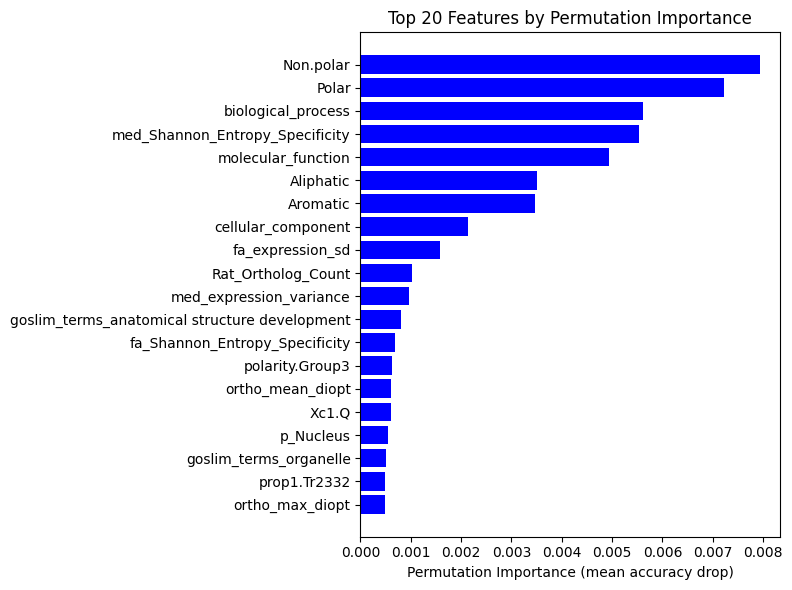

In [ ]:
# 1) Get the selected feature names (must supply the same args as before)
selected_feats = get_selected_feature_names(
    tuned_rf_pipeline, numerical_cols, onehot_cols, multilabel_transformer
)
# selected_feats should be length == len(importances)

# 2) Build a DataFrame and sort descending
df_imp = pd.DataFrame({
    "feature": selected_feats,
    "importance": importances
}).sort_values(by="importance", ascending=False).reset_index(drop=True)

# 3) Inspect the top 10
print(df_imp.head(10))

# 4) (Optional) Plot the top 20 as a horizontal bar chart
import matplotlib.pyplot as plt

top_n = 20
top_df = df_imp.head(top_n).iloc[::-1]  # reverse so highest sits at the top

plt.figure(figsize=(8, 6))
plt.barh(top_df["feature"], top_df["importance"], color="blue")
plt.xlabel("Permutation Importance (mean accuracy drop)")
plt.title(f"Top {top_n} Features by Permutation Importance")
plt.tight_layout()
plt.show()

                                             feature  importance
0                                med_mean_expression    0.133191
1                              med_median_expression    0.033104
2      goslim_terms_anatomical structure development    0.021333
3                                 molecular_function    0.017978
4                                  transcript_length    0.017888
5                                 biological_process    0.017832
6                                    ortho_max_diopt    0.017768
7                             goslim_terms_organelle    0.014055
8  fa_tissue_with_max_expression_RNA-Seq_Profile_...    0.008148
9                    med_Shannon_Entropy_Specificity    0.007066


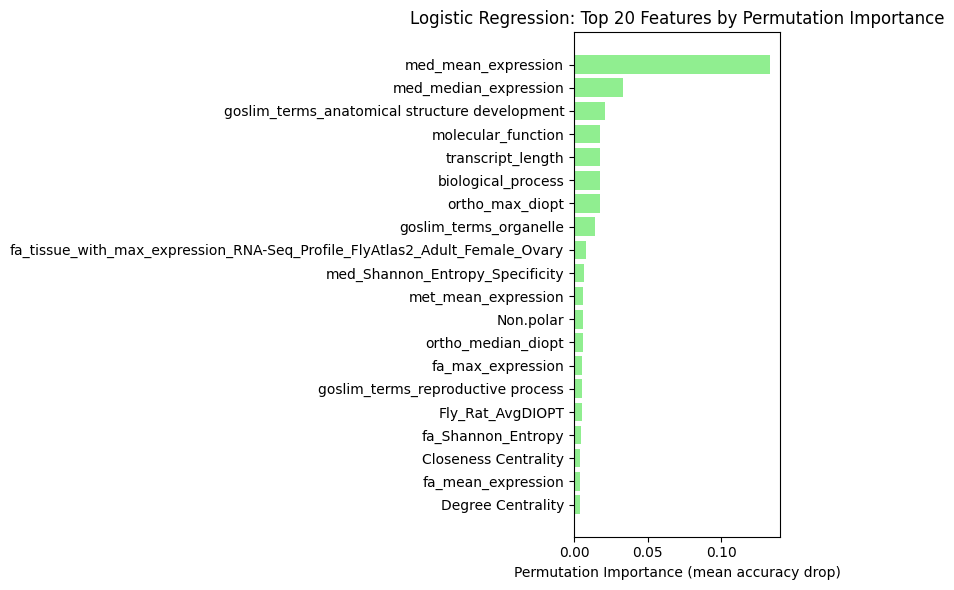

In [ ]:
# repeat for LR
# 1) Extract the reduced test set exactly as before:
X_pre = lr_pipeline.named_steps['preprocessing'].transform(X_test)
X_var = lr_pipeline.named_steps['variance'].transform(X_pre)
X_kb  = lr_pipeline.named_steps['select_kbest'].transform(X_var)
X_sel = lr_pipeline.named_steps['select_model'].transform(X_kb)

# 2) Grab the trained LogisticRegression from its pipeline:
lr_clf = lr_pipeline.named_steps['clf']   # assuming lr_pipeline is your binary‐LR pipeline

# 3) Compute permutation importance on X_sel versus y_test:
lr_result = permutation_importance(
    lr_clf,
    X_sel,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

lr_importances = lr_result.importances_mean  # length == n_selected

selected_feats = get_selected_feature_names(
    lr_pipeline,
    numerical_cols,
    onehot_cols,
    multilabel_transformer
)

assert len(selected_feats) == len(lr_importances)

df_lr_imp = pd.DataFrame({
    "feature": selected_feats,
    "importance": lr_importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

# 3) Inspect the top 10
print(df_lr_imp.head(10))

# 4) plot
top20 = df_lr_imp.head(20).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(top20["feature"], top20["importance"], color="lightgreen")
plt.xlabel("Permutation Importance (mean accuracy drop)")
plt.title("Logistic Regression: Top 20 Features by Permutation Importance")
plt.tight_layout()
plt.show()

                                         feature  importance
0                                      Aliphatic    0.023212
1                                      Non.polar    0.018540
2                                          Polar    0.017983
3                             molecular_function    0.016891
4                           solventaccess.Group1    0.014681
5                             biological_process    0.009135
6                                      p_Nucleus    0.008385
7  goslim_terms_anatomical structure development    0.007766
8                              cdna_coding_start    0.007685
9                             cellular_component    0.007181


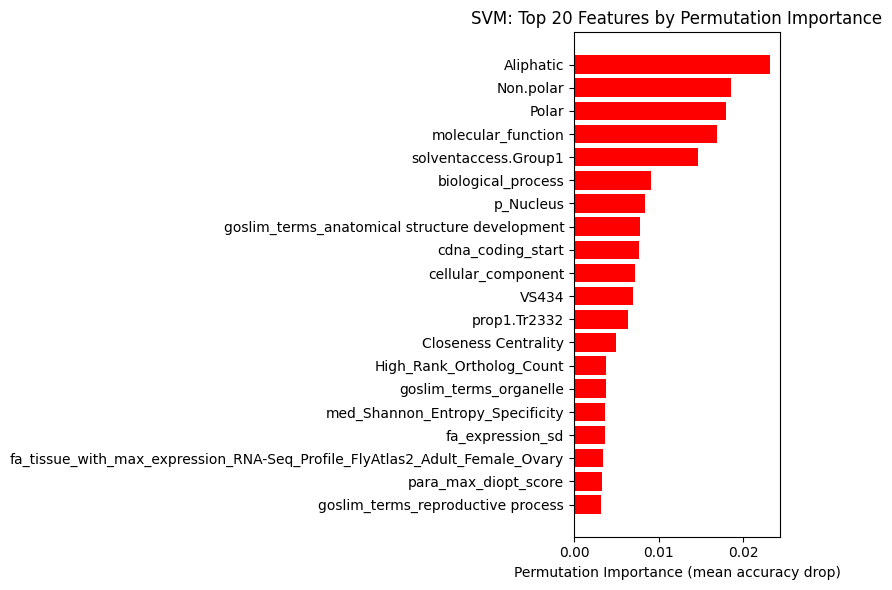

In [ ]:
# repeat for SVM
# 1) Extract the reduced test set exactly as before:
X_pre = svm_pipeline.named_steps['preprocessing'].transform(X_test)
X_var = svm_pipeline.named_steps['variance'].transform(X_pre)
X_kb  = svm_pipeline.named_steps['select_kbest'].transform(X_var)
X_sel = svm_pipeline.named_steps['select_model'].transform(X_kb)

# 2) Grab the trained LogisticRegression from its pipeline:
svm_clf = svm_pipeline.named_steps['clf']   # assuming lr_pipeline is your binary‐LR pipeline

# 3) Compute permutation importance on X_sel versus y_test:
svm_result = permutation_importance(
    svm_clf,
    X_sel,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

svm_importances = svm_result.importances_mean  # length == n_selected

selected_feats = get_selected_feature_names(
    svm_pipeline,
    numerical_cols,
    onehot_cols,
    multilabel_transformer
)

assert len(selected_feats) == len(svm_importances)

df_svm_imp = pd.DataFrame({
    "feature": selected_feats,
    "importance": svm_importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

# 3) Inspect the top 10
print(df_svm_imp.head(10))

# 4) plot
top20 = df_svm_imp.head(20).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(top20["feature"], top20["importance"], color="red")
plt.xlabel("Permutation Importance (mean accuracy drop)")
plt.title("SVM: Top 20 Features by Permutation Importance")
plt.tight_layout()
plt.show()

                                         feature  importance
0                                      Non.polar    0.047238
1                med_Shannon_Entropy_Specificity    0.030823
2                                          Polar    0.015116
3                             molecular_function    0.010756
4                             biological_process    0.009257
5                                      Aliphatic    0.008667
6                               fa_expression_sd    0.003859
7                        med_expression_variance    0.003053
8                             cellular_component    0.002885
9  goslim_terms_anatomical structure development    0.001913


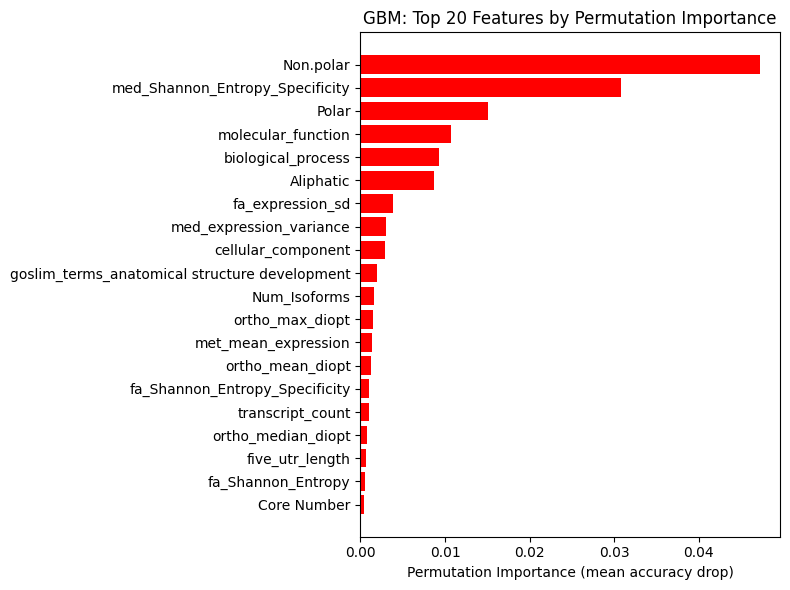

In [ ]:
# repeat for GBM
# 1) Extract the reduced test set exactly as before:
X_pre = gbm_pipeline.named_steps['preprocessing'].transform(X_test)
X_var = gbm_pipeline.named_steps['variance'].transform(X_pre)
X_kb  = gbm_pipeline.named_steps['select_kbest'].transform(X_var)
X_sel = gbm_pipeline.named_steps['select_model'].transform(X_kb)

# 2) Grab the trained LogisticRegression from its pipeline:
gbm_clf = gbm_pipeline.named_steps['clf']   # assuming lr_pipeline is your binary‐LR pipeline

# 3) Compute permutation importance on X_sel versus y_test:
gbm_result = permutation_importance(
    gbm_clf,
    X_sel,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

gbm_importances = gbm_result.importances_mean  # length == n_selected

selected_feats = get_selected_feature_names(
    gbm_pipeline,
    numerical_cols,
    onehot_cols,
    multilabel_transformer
)

assert len(selected_feats) == len(gbm_importances)

df_gbm_imp = pd.DataFrame({
    "feature": selected_feats,
    "importance": gbm_importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

# 3) Inspect the top 10
print(df_gbm_imp.head(10))

# 4) plot
top20 = df_gbm_imp.head(20).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(top20["feature"], top20["importance"], color="red")
plt.xlabel("Permutation Importance (mean accuracy drop)")
plt.title("GBM: Top 20 Features by Permutation Importance")
plt.tight_layout()
plt.show()

                           feature  importance
0                        Aliphatic    0.047578
1  med_Shannon_Entropy_Specificity    0.027061
2                            Polar    0.014088
3               molecular_function    0.012513
4               biological_process    0.010978
5   fa_Shannon_Entropy_Specificity    0.009932
6                        Non.polar    0.009130
7               cellular_component    0.007043
8                 fa_expression_sd    0.005951
9                 ortho_mean_diopt    0.005058


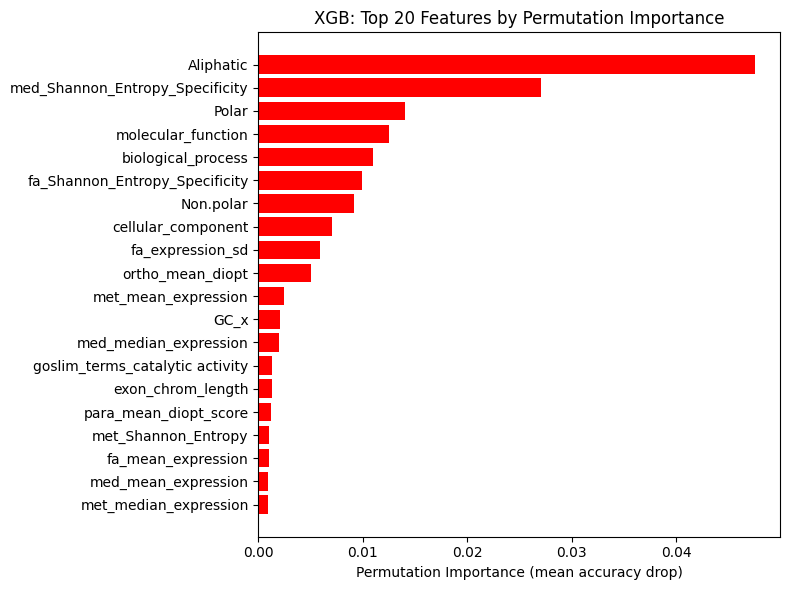

In [ ]:
# repeat for SVM
# 1) Extract the reduced test set exactly as before:
X_pre = xgb_pipeline.named_steps['preprocessing'].transform(X_test)
X_var = xgb_pipeline.named_steps['variance'].transform(X_pre)
X_kb  = xgb_pipeline.named_steps['select_kbest'].transform(X_var)
X_sel = xgb_pipeline.named_steps['select_model'].transform(X_kb)

# 2) Grab the trained LogisticRegression from its pipeline:
xgb_clf = xgb_pipeline.named_steps['clf']   # assuming lr_pipeline is your binary‐LR pipeline

# 3) Compute permutation importance on X_sel versus y_test:
xgb_result = permutation_importance(
    xgb_clf,
    X_sel,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

xgb_importances = xgb_result.importances_mean  # length == n_selected

selected_feats = get_selected_feature_names(
    xgb_pipeline,
    numerical_cols,
    onehot_cols,
    multilabel_transformer
)

assert len(selected_feats) == len(xgb_importances)

df_xgb_imp = pd.DataFrame({
    "feature": selected_feats,
    "importance": xgb_importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

# 3) Inspect the top 10
print(df_xgb_imp.head(10))

# 4) plot
top20 = df_xgb_imp.head(20).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(top20["feature"], top20["importance"], color="red")
plt.xlabel("Permutation Importance (mean accuracy drop)")
plt.title("XGB: Top 20 Features by Permutation Importance")
plt.tight_layout()
plt.show()

                          feature  importance
0                           Polar    0.030693
1                       Non.polar    0.030603
2            solventaccess.Group1    0.030242
3                       Aliphatic    0.025581
4              molecular_function    0.020059
5              biological_process    0.018952
6             med_mean_expression    0.014428
7  fa_Shannon_Entropy_Specificity    0.013436
8                 ortho_max_diopt    0.012707
9                    prop1.Tr2332    0.010822


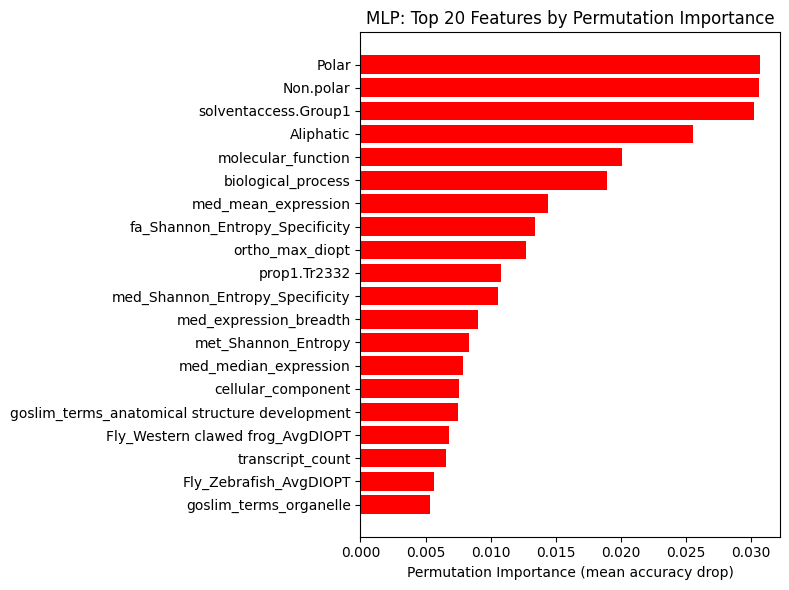

In [ ]:
# repeat for MLP
# 1) Extract the reduced test set exactly as before:
X_pre = mlp_pipeline.named_steps['preprocessing'].transform(X_test)
X_var = mlp_pipeline.named_steps['variance'].transform(X_pre)
X_kb  = mlp_pipeline.named_steps['select_kbest'].transform(X_var)
X_sel = mlp_pipeline.named_steps['select_model'].transform(X_kb)

# 2) Grab the trained LogisticRegression from its pipeline:
mlp_clf = mlp_pipeline.named_steps['clf']   # assuming lr_pipeline is your binary‐LR pipeline

# 3) Compute permutation importance on X_sel versus y_test:
mlp_result = permutation_importance(
    mlp_clf,
    X_sel,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

mlp_importances = mlp_result.importances_mean  # length == n_selected

selected_feats = get_selected_feature_names(
    mlp_pipeline,
    numerical_cols,
    onehot_cols,
    multilabel_transformer
)

assert len(selected_feats) == len(mlp_importances)

df_mlp_imp = pd.DataFrame({
    "feature": selected_feats,
    "importance": mlp_importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

# 3) Inspect the top 10
print(df_mlp_imp.head(10))

# 4) plot
top20 = df_mlp_imp.head(20).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(top20["feature"], top20["importance"], color="red")
plt.xlabel("Permutation Importance (mean accuracy drop)")
plt.title("MLP: Top 20 Features by Permutation Importance")
plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter

# Collect all top 20 lists into one big list
all_top30 = (list(df_lr_imp['feature'].head(30)) +
             list(df_svm_imp['feature'].head(30)) +
             list(df_imp['feature'].head(30)) +
             list(df_gbm_imp['feature'].head(30)) +
             list(df_xgb_imp['feature'].head(30)) +
             list(df_mlp_imp['feature'].head(30)))

freq = Counter(all_top30)
# Keep features that appear in ≥ 4 of the six lists
common_loose = [feat for feat, count in freq.items() if count >= 4]


In [ ]:
common_loose

['med_median_expression',
 'goslim_terms_anatomical structure development',
 'molecular_function',
 'biological_process',
 'ortho_max_diopt',
 'goslim_terms_organelle',
 'fa_tissue_with_max_expression_RNA-Seq_Profile_FlyAtlas2_Adult_Female_Ovary',
 'med_Shannon_Entropy_Specificity',
 'met_mean_expression',
 'Non.polar',
 'goslim_terms_reproductive process',
 'fa_mean_expression',
 'Aliphatic',
 'Polar',
 'p_Nucleus',
 'cellular_component',
 'fa_expression_sd',
 'fa_Shannon_Entropy_Specificity',
 'ortho_mean_diopt']

In [ ]:
all_top30 = (
    list(df_lr_imp['feature'].head(30)) +
    list(df_svm_imp['feature'].head(30)) +
    list(df_imp['feature'].head(30)) +           # df_imp is RF’s importances
    list(df_gbm_imp['feature'].head(30)) +
    list(df_xgb_imp['feature'].head(30)) +
    list(df_mlp_imp['feature'].head(30))
)
freq = Counter(all_top30)

# Keep features that appear in ≥ 4 of the six “top 30” lists
common_loose = [feat for feat, count in freq.items() if count >= 4]

print("Features in ≥4/6 top-30 lists:", common_loose)

Features in ≥4/6 top-30 lists: ['med_median_expression', 'goslim_terms_anatomical structure development', 'molecular_function', 'biological_process', 'ortho_max_diopt', 'goslim_terms_organelle', 'fa_tissue_with_max_expression_RNA-Seq_Profile_FlyAtlas2_Adult_Female_Ovary', 'med_Shannon_Entropy_Specificity', 'met_mean_expression', 'Non.polar', 'goslim_terms_reproductive process', 'fa_mean_expression', 'Aliphatic', 'Polar', 'p_Nucleus', 'cellular_component', 'fa_expression_sd', 'fa_Shannon_Entropy_Specificity', 'ortho_mean_diopt']


Features in ≥4/6 top-25 lists: ['med_median_expression', 'goslim_terms_anatomical structure development', 'molecular_function', 'biological_process', 'ortho_max_diopt', 'goslim_terms_organelle', 'med_Shannon_Entropy_Specificity', 'met_mean_expression', 'Non.polar', 'Aliphatic', 'Polar', 'cellular_component', 'fa_expression_sd', 'fa_Shannon_Entropy_Specificity']


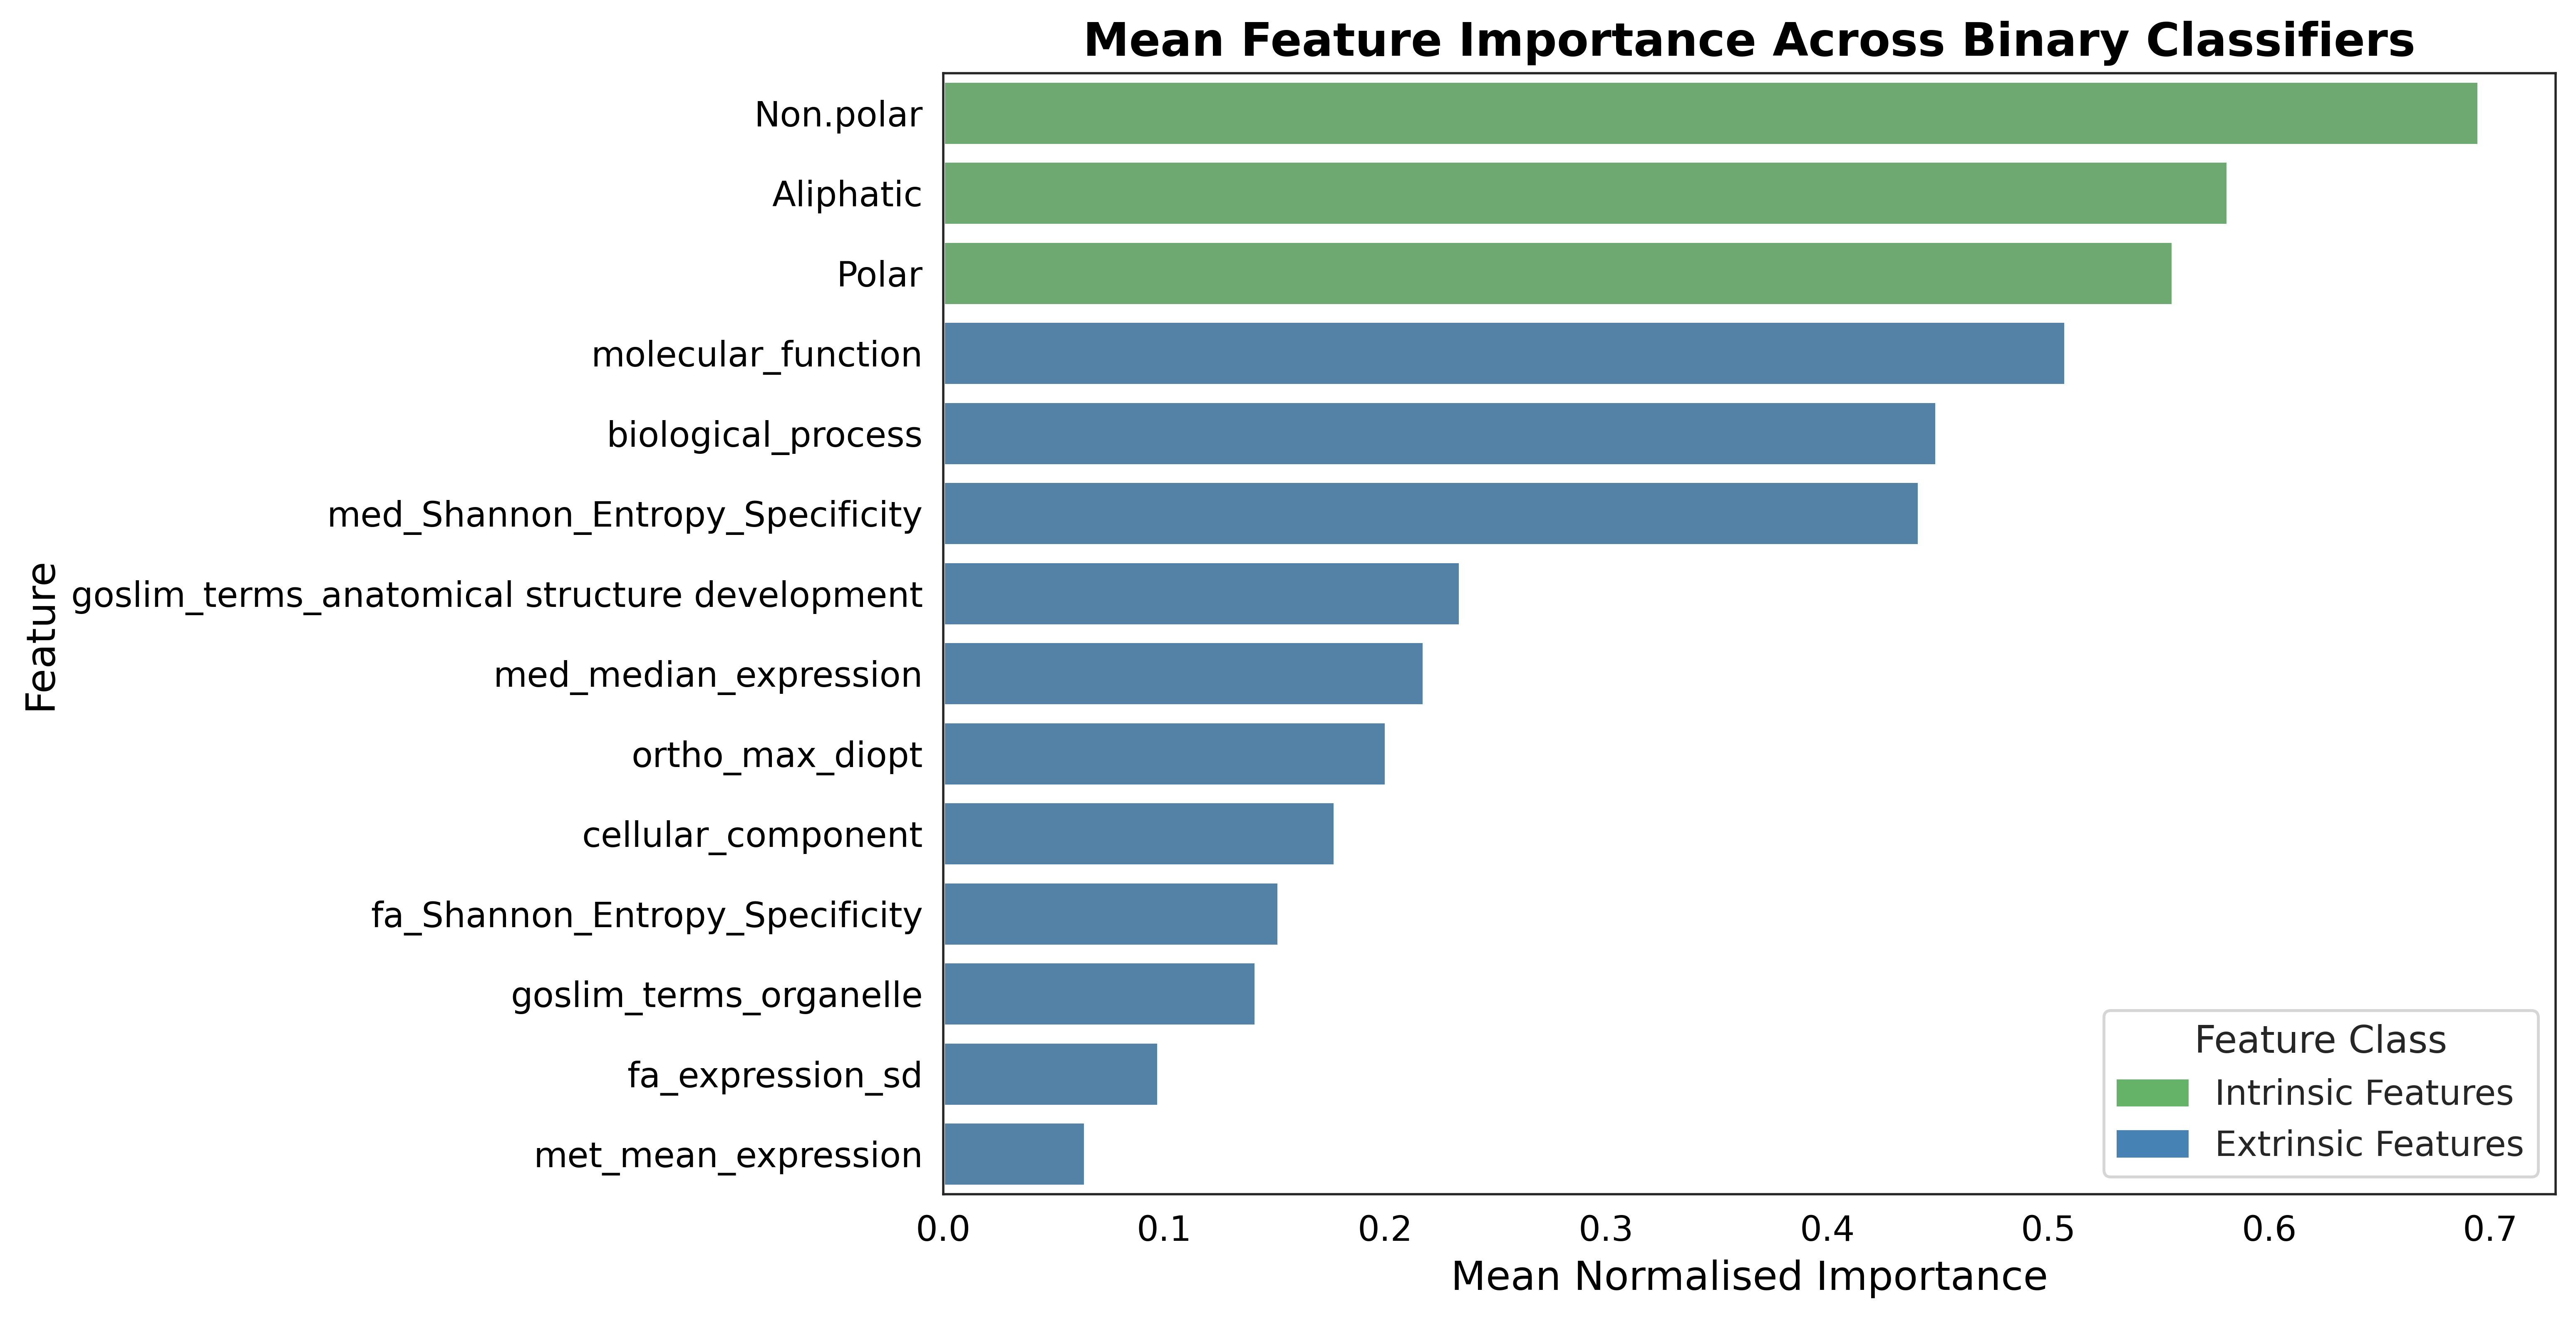

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches

# 1) Identify features appearing in ≥4 of the six top-25 lists
all_top25 = (
    list(df_lr_imp['feature'].head(25)) +
    list(df_svm_imp['feature'].head(25)) +
    list(df_imp['feature'].head(25)) +      # df_imp is RF
    list(df_gbm_imp['feature'].head(25)) +
    list(df_xgb_imp['feature'].head(25)) +
    list(df_mlp_imp['feature'].head(25))
)
freq = Counter(all_top25)
common_loose = [feat for feat, count in freq.items() if count >= 4]
print("Features in ≥4/6 top-25 lists:", common_loose)

# 2) Extract importance series for these features from each classifier
series_lr  = df_lr_imp.set_index('feature')['importance'].reindex(common_loose)
series_svm = df_svm_imp.set_index('feature')['importance'].reindex(common_loose)
series_rf  = df_imp.set_index('feature')['importance'].reindex(common_loose)
series_gbm = df_gbm_imp.set_index('feature')['importance'].reindex(common_loose)
series_xgb = df_xgb_imp.set_index('feature')['importance'].reindex(common_loose)
series_mlp = df_mlp_imp.set_index('feature')['importance'].reindex(common_loose)

# 3) Create DataFrame with all importances, fill missing with 0
df_common_loose = pd.DataFrame({
    'LogisticRegression': series_lr.fillna(0),
    'SVM':                series_svm.fillna(0),
    'RandomForest':       series_rf.fillna(0),
    'GradientBoosting':   series_gbm.fillna(0),
    'XGBoost':            series_xgb.fillna(0),
    'MLP':                series_mlp.fillna(0)
}, index=common_loose)

# 4) Min-max normalization function
def min_max_normalize(series):
    if series.max() == series.min():
        return series - series.min()
    return (series - series.min()) / (series.max() - series.min())

# 5) Normalize per classifier
df_minmax = df_common_loose.apply(min_max_normalize)

# 6) Mean importance across classifiers
df_minmax['mean_importance'] = df_minmax.mean(axis=1)

# 7) Sort by mean importance
df_minmax = df_minmax.sort_values('mean_importance', ascending=False)

# Feature class color coding
intrinsic_features = set(['Non.polar', 'Polar', 'Aliphatic'])
bar_colors = ['#64b369' if feat in intrinsic_features else 'steelblue' for feat in df_minmax.index]

# Legend patches
intrinsic_patch = mpatches.Patch(color='#64b369', label='Intrinsic Features')
extrinsic_patch = mpatches.Patch(color='steelblue', label='Extrinsic Features')

# 8) Plot
plt.figure(figsize=(10, max(6, len(df_minmax) * 0.5)), dpi = 500)
sns.barplot(
    x=df_minmax['mean_importance'],
    y=df_minmax.index,
    palette=bar_colors
)

# Professional styling
plt.xlabel('Mean Normalised Importance', fontsize=14, color='black')
plt.ylabel('Feature', fontsize=14, color='black')
plt.title('Mean Feature Importance Across Binary Classifiers', fontsize=16, weight='bold', color='black')

plt.xticks(color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)
plt.legend(handles=[intrinsic_patch, extrinsic_patch], title='Feature Class', loc='lower right', fontsize=12, title_fontsize=13)
# Set black tick labels
ax.tick_params(axis='x', colors='black', direction='out', length=5, width=1)
ax.tick_params(axis='y', colors='black', direction='out', length=5, width=1)

# Set font size for tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.grid(False)
plt.savefig("binary_mean_feature_importances.png", dpi=500)
# Show the figure
plt.show()


Features in ≥4/6 top-25 lists: ['med_median_expression', 'goslim_terms_anatomical structure development', 'molecular_function', 'biological_process', 'ortho_max_diopt', 'goslim_terms_organelle', 'med_Shannon_Entropy_Specificity', 'met_mean_expression', 'Non.polar', 'Aliphatic', 'Polar', 'cellular_component', 'fa_expression_sd', 'fa_Shannon_Entropy_Specificity']


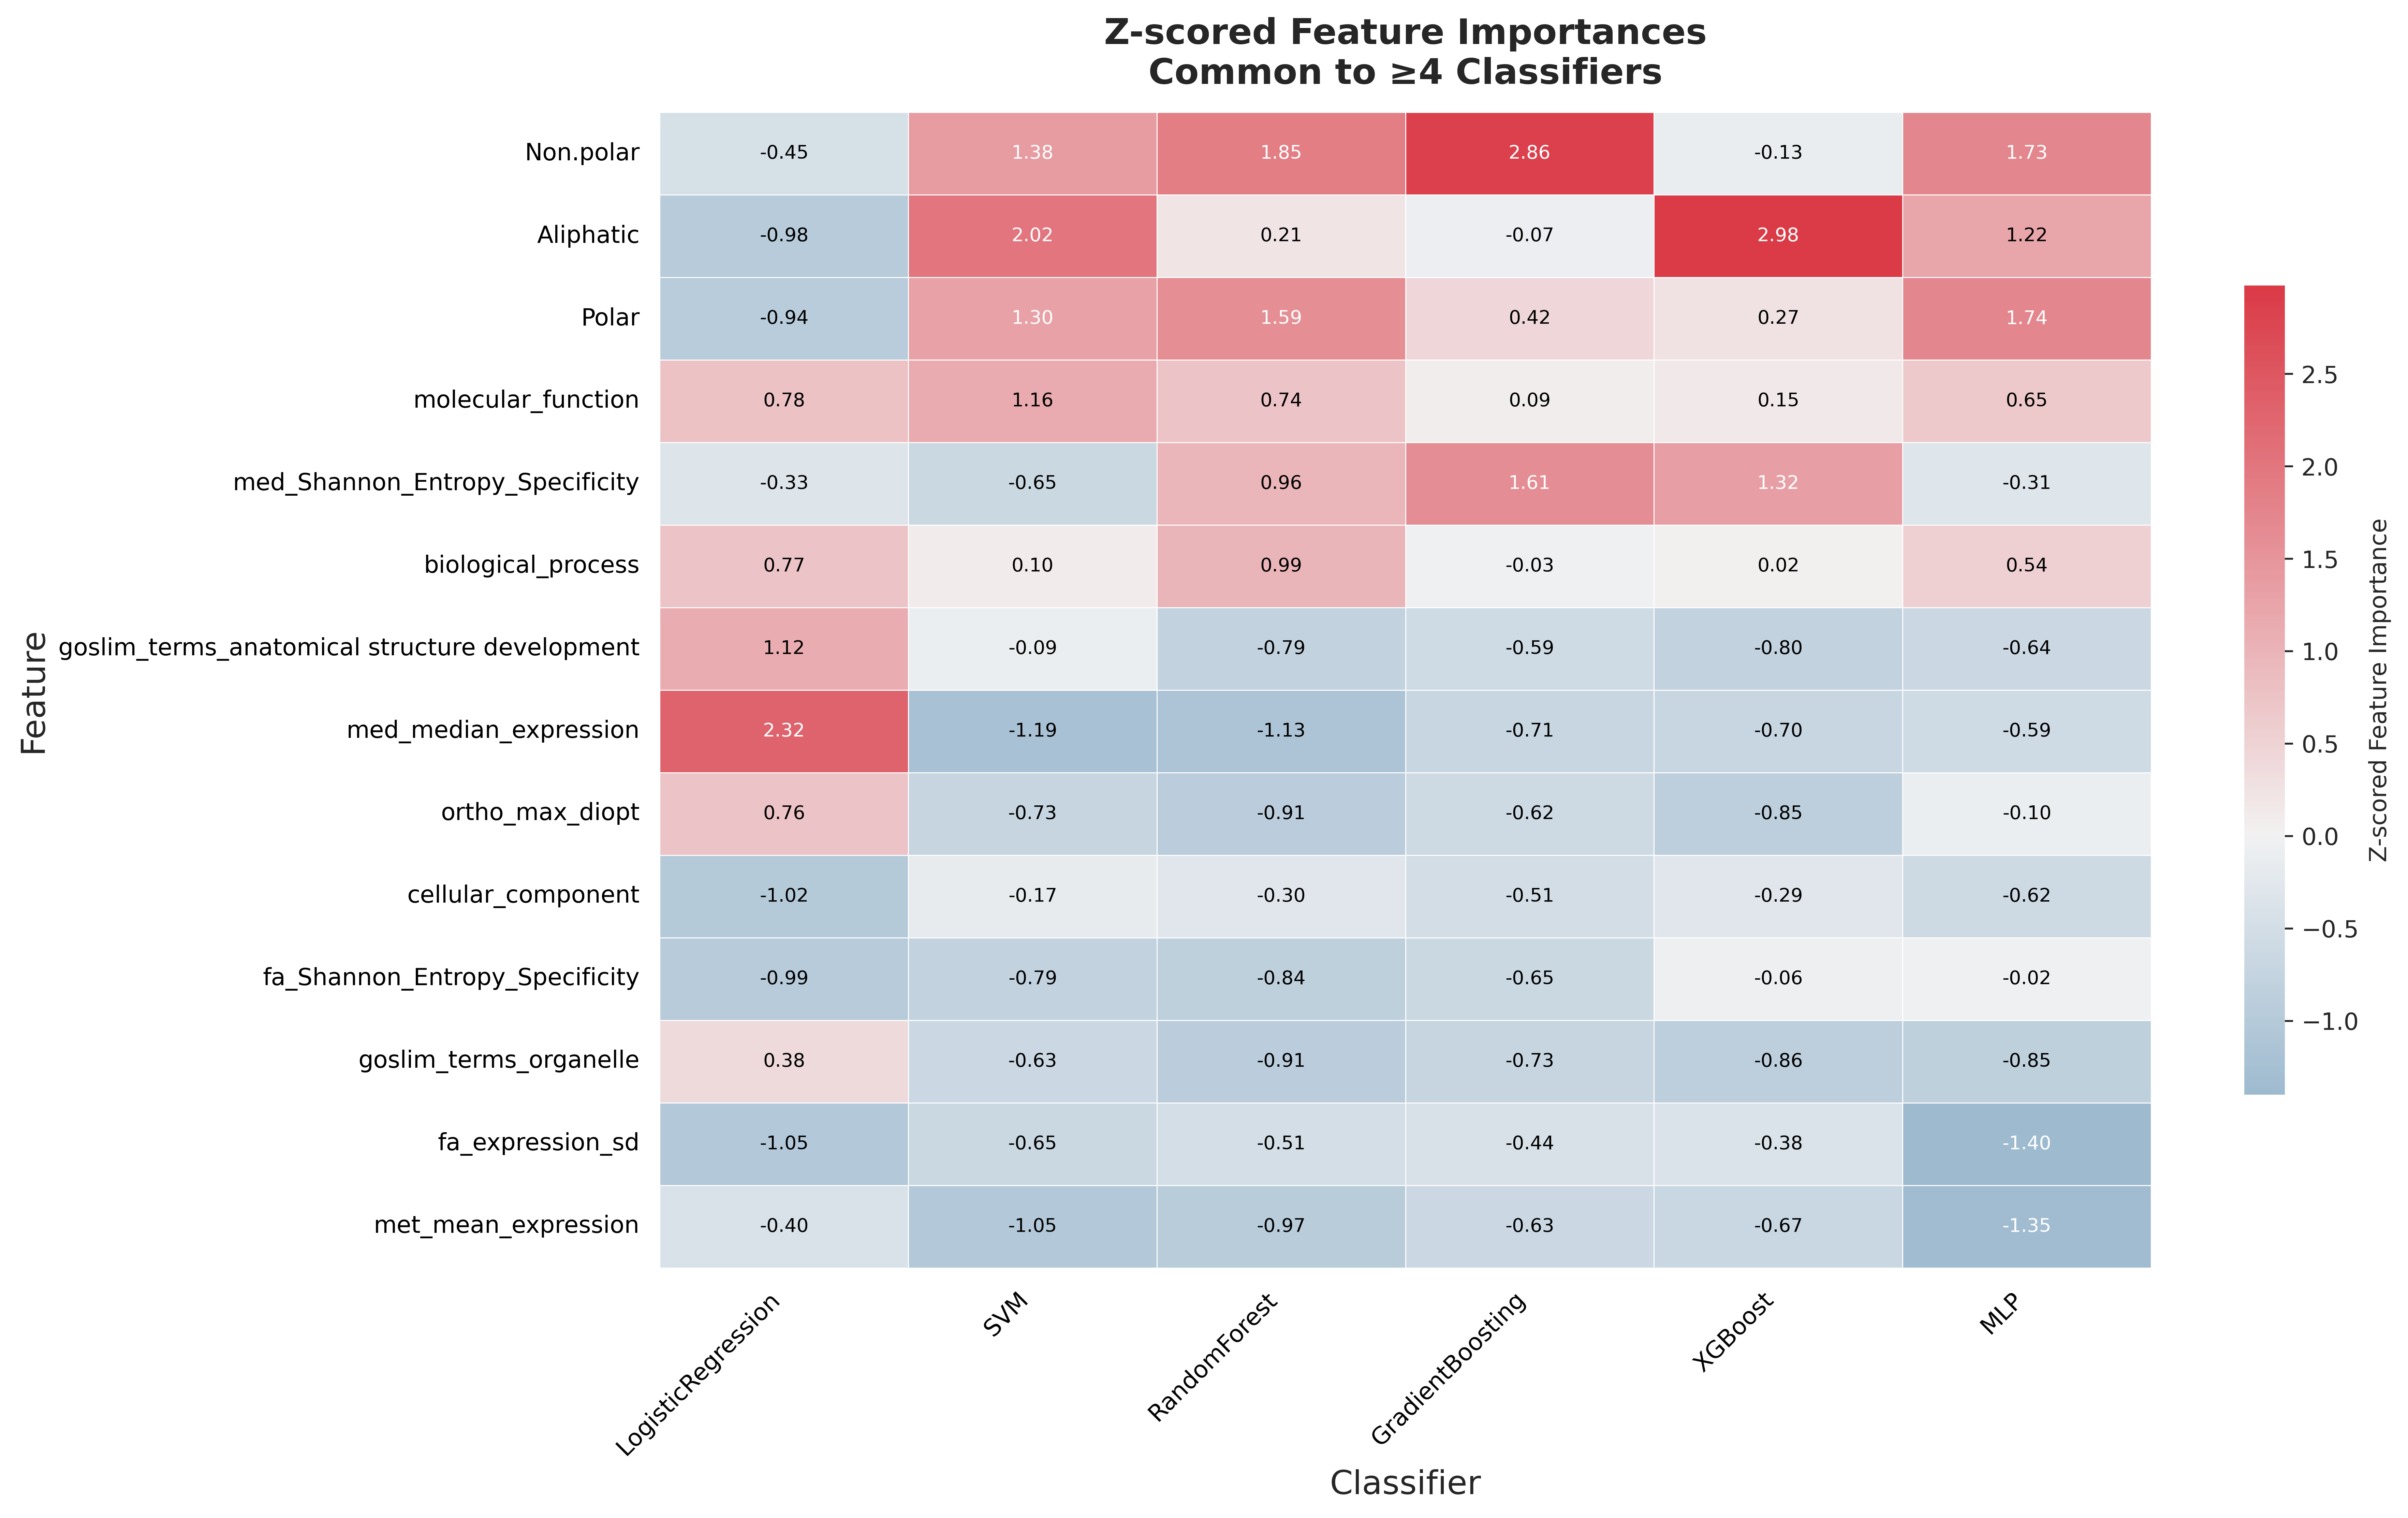

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import zscore

# 1) Identify features appearing in ≥4 of the six top-25 lists
all_top25 = (
    list(df_lr_imp['feature'].head(25)) +
    list(df_svm_imp['feature'].head(25)) +
    list(df_imp['feature'].head(25)) +      # df_imp is RF
    list(df_gbm_imp['feature'].head(25)) +
    list(df_xgb_imp['feature'].head(25)) +
    list(df_mlp_imp['feature'].head(25))
)
freq = Counter(all_top25)
common_loose = [feat for feat, count in freq.items() if count >= 4]
print("Features in ≥4/6 top-25 lists:", common_loose)

# 2) Extract importance series for these features from each classifier
series_lr  = df_lr_imp.set_index('feature')['importance'].reindex(common_loose)
series_svm = df_svm_imp.set_index('feature')['importance'].reindex(common_loose)
series_rf  = df_imp.set_index('feature')['importance'].reindex(common_loose)
series_gbm = df_gbm_imp.set_index('feature')['importance'].reindex(common_loose)
series_xgb = df_xgb_imp.set_index('feature')['importance'].reindex(common_loose)
series_mlp = df_mlp_imp.set_index('feature')['importance'].reindex(common_loose)

# 3) Create DataFrame with all importances, fill missing with 0
df_common_loose = pd.DataFrame({
    'LogisticRegression': series_lr.fillna(0),
    'SVM':                series_svm.fillna(0),
    'RandomForest':       series_rf.fillna(0),
    'GradientBoosting':   series_gbm.fillna(0),
    'XGBoost':            series_xgb.fillna(0),
    'MLP':                series_mlp.fillna(0)
}, index=common_loose)

# 4) Z-score normalize each classifier (column) independently
df_norm = df_common_loose.apply(zscore)

# 5) Sort features by mean normalized importance across classifiers (descending)
df_norm['mean_imp'] = df_norm.mean(axis=1)
df_norm = df_norm.sort_values('mean_imp', ascending=False)
df_plot = df_norm.drop(columns='mean_imp')

# 6) Plot heatmap
# 6) Plot heatmap with pretty diverging palette
import numpy as np

# Define the diverging palette — more elegant than hardcoding 'RdBu_r'
cmap = sns.diverging_palette(240, 10, as_cmap=True)  # blue-red, cool to warm

plt.figure(figsize=(fig_width, fig_height), dpi=500)
ax = sns.heatmap(
    df_plot,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    center=0,
    linewidths=0.4,
    linecolor='white',
    cbar_kws={'label': 'Z-scored Feature Importance', 'shrink': 0.7},
    annot_kws={"size": 8}
)

# Dynamically adjust text color for readability
for text in ax.texts:
    try:
        val = float(text.get_text())
        text.set_color("white" if abs(val) > 1.25 else "black")
    except ValueError:
        continue

# Axis labeling and title
ax.set_xlabel("Classifier", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
ax.set_title("Z-scored Feature Importances\nCommon to ≥4 Classifiers", fontsize=15, weight='bold', pad=12)

# Tick formatting
plt.xticks(rotation=45, ha='right', fontsize=10, color='black')
plt.yticks(rotation=0, fontsize=10, color='black')
ax.tick_params(axis='both', colors='black', direction='out', length=5, width=1)

plt.tight_layout()
plt.savefig("binary_permutation_importances.png", dpi=500, bbox_inches='tight')
plt.show()